In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, ttest_ind, chi2_contingency, poisson
import statsmodels.api as sm
import itertools
from statsmodels.stats.outliers_influence import variance_inflation_factor


data = pd.read_csv('dane_projekt1.csv', sep=';')

print(data.head())
print(data.info())
print(data.isnull().sum())


    id   waga  wzrost  plec  dzieci  wiek   dochod  oszczednosci  jednoos  \
0   52  78.93  176.20     2       5    59   979.01        673.17        0   
1  101  78.66  165.73     1       3    52  1043.36        543.89        0   
2  146  74.29  171.33     1       2    57  1227.69        773.20        0   
3  281  79.11  169.24     1       1    59  2356.74       1914.74        1   
4  167  79.23  177.78     2       1    48  1264.95        536.29        1   

   miejsce  wydatki_zyw  
0        3       194.96  
1        2       259.20  
2        1       244.41  
3        2       239.77  
4        3       291.05  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            310 non-null    int64  
 1   waga          310 non-null    float64
 2   wzrost        310 non-null    float64
 3   plec          310 non-null    int64  
 4   dzieci       

### 1.1
Zbiór zawiera 10 zmiennych, z czego 7 zmiennych to zmienne ilościowe, a 3 zmienne to zmienne jakościowe. Brak danych nie występuje, ponieważ liczba obserwacji dla każdej zmiennej jest równa 310.

Zmienne ilościowe to:
- Waga (w kg)
- Wzrost (w cm)
- Dzieci (liczba dzieci na utrzymaniu respondenta)
- Wiek (w latach)
- Dochód (deklarowany dochód respondenta w badanym miesiącu, w bajtalarach)
- Oszczędności (deklarowane oszczędności respondenta w badanym miesiącu, w bajtalarach)
- Wydatki_zyw (deklarowane wydatki na żywność respondenta w badanym miesiącu, w bajtalarach)
  
Zmienne jakościowe to:
- Płeć (1 - "kobieta", 2 - "mężczyzna")
- Jednoos (status gospodarstwa domowego, 1 - "gospodarstwo jednoosobowe", 0 - "gospodarstwo wieloosobowe")
- Miejsce (wielkość miejscowości, 1 - "do 10 000 mieszkańców", 2 - "od 10 000 mieszkańców do 100 000 mieszkańców", 3 - "powyżej 100 000 mieszkańców")

Technicznie rzecz biorąc, ID jest mogłaby być również zmienną jakościową, ponieważ domyślnie nie musi mieć numeru, w interpretacji że to liczba to mogłaby być zmienną ilościową, jednak w kontekście analizy danych zadania nie dostarcza informacji analitycznej (poza identyfikacją rekordów), dlatego potraktujemy je jako kolumne indeksowa w ramce danych, dalej nie jest nam potrzebna zatem ją wyrzucimy.

In [2]:
data = data.drop('id', axis=1)
data.describe()

,waga,wzrost,plec,dzieci,wiek,dochod,oszczednosci,jednoos,miejsce,wydatki_zyw
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,79.814742,172.726774,1.458065,2.003226,56.241935,1519.658000,945.994839,0.429032,2.003226,12.383097
std,3.292902,6.906733,0.499044,1.352209,6.746653,1293.464325,787.601212,0.495738,0.739537,3232.382607
min,68.890000,155.670000,1.000000,0.000000,37.000000,645.270000,-204.240000,0.000000,1.000000,-55640.190000
25%,77.430000,167.090000,1.000000,1.000000,52.000000,966.807500,392.545000,0.000000,1.000000,199.757500
50%,79.890000,172.815000,1.000000,2.000000,56.000000,1190.840000,741.190000,0.000000,2.000000,249.265000
75%,82.112500,178.032500,2.000000,3.000000,61.000000,1620.460000,1270.222500,1.000000,3.000000,283.267500
max,86.730000,190.790000,2.000000,5.000000,77.000000,17412.240000,5485.220000,1.000000,3.000000,301.690000


### 1.2a
Możemy dostrzec dziwną przypadłość - wydatki_zyw są też ujemne, jest to niezgodne z treścią, wiec musimy usunąć takowe błędne rekordy zgodnie z zaleceniami. Pozostałe wartości z różnych kolumn nie rzucają się w oczy z błędami.
###
Dalej przedstawimy tabele częstości dla zmiennych jakościowych, a także statystyki opisowe dla zmiennych ilościowych.

In [3]:
data = data[data['wydatki_zyw'] >= 0]
categorical_vars = ['plec', 'jednoos', 'miejsce']
numeric_vars = ['waga', 'wzrost', 'dzieci', 'wiek', 'dochod', 'oszczednosci', 'wydatki_zyw']

for var in categorical_vars:
    print(data[var].value_counts())

data[numeric_vars].describe()

plec
1    163
2    141
Name: count, dtype: int64
jednoos
0    177
1    127
Name: count, dtype: int64
miejsce
2    138
3     83
1     83
Name: count, dtype: int64


,waga,wzrost,dzieci,wiek,dochod,oszczednosci,wydatki_zyw
count,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000
mean,79.819309,172.805757,1.990132,56.259868,1389.315724,887.975954,235.571151
std,3.303614,6.935242,1.341112,6.782444,660.781113,668.759849,57.232769
min,68.890000,155.670000,0.000000,37.000000,645.270000,-204.240000,56.270000
25%,77.415000,167.130000,1.000000,51.750000,965.830000,384.657500,204.207500
50%,79.895000,172.890000,2.000000,56.500000,1181.350000,722.325000,250.465000
75%,82.142500,178.117500,3.000000,61.000000,1613.947500,1236.880000,284.110000
max,86.730000,190.790000,5.000000,77.000000,4780.150000,3390.590000,301.690000


### 1.2b
Podsumowanie danych (pozostało 304 rekordów):

1. **Waga i Wzrost:** Średnia waga wynosi około 79.82 kg, a średni wzrost to około 172.81 cm. Zarówno waga, jak i wzrost mają niskie odchylenie standardowe, co sugeruje, że dane te są stosunkowo zbliżone do średnich wartości.

2. **Liczba Dzieci:** Średnia liczba dzieci wynosi około 1.99, a odchylenie standardowe wynosi około 1.34. Wartości te mieszczą się w przedziale od 0 do 5 dzieci. Być może warto byłoby podzielić ich ilość na kategorie np 5 różnych: 0,1,2,3,4+

3. **Wiek:** Średni wiek wynosi około 56.26 lat, a odchylenie standardowe wynosi około 6.78 lat. Wartości wieku mieszczą się w przedziale od 37 do 77 lat. Pokazuje to że nie byli badani ludzie młodzi.

4. **Dochód:** Średni dochód wynosi około 1389.32 jednostek, przy odchyleniu standardowym około 660.78. Widzimy dużą zmienność w danych dotyczących dochodu, co jest zrozumiałe. Dziwi mnie tylko że najbardziej dochodowy ankietowany miał pensję tylko około 7 razy wyższą od najmniej dochodowego, co sprawia wrażenie braku oligarchów w Bajtocji.

5. **Oszczędności:** Średnia wartość oszczędności wynosi około 887.98 jednostek, a odchylenie standardowe to około 668.76. Podobnie jak w przypadku dochodu, oszczędności również wykazują dużą zmienność (i podobną różnicę między max a min 4100 oraz 3600).

6. **Wydatki Żywnościowe:** Średnie wydatki na żywność wynoszą około 235.57 jednostek, a odchylenie standardowe to około 57.23. Wartości te mieszczą się w przedziale od około 56.27 do 301.69 jednostek.

Ciekawe obserwacje:

- Mediany wagi, wzrostu, dzieci i wieku zbliżone są do średniej, co sugeruje, że rozkłady tych zmiennych są symetryczne, jak w rozkładzie normalnym.
- Średni dochód i oszczędności jest wyższy niż mediana, co sugeruje, że rozkład dochodu może być prawoskośny, czyli z przewagą wyższych wartości, lewoskośny dla wydatków na żywność.

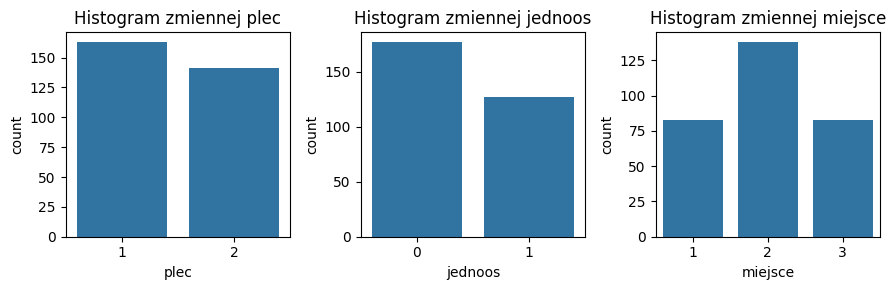

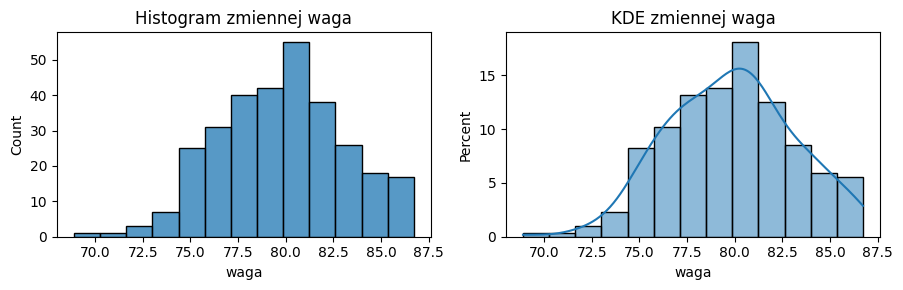

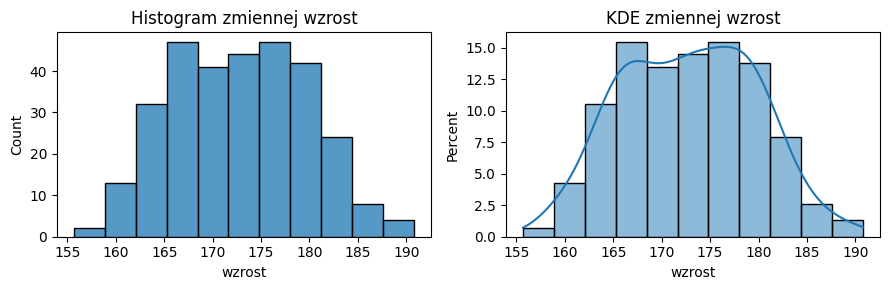

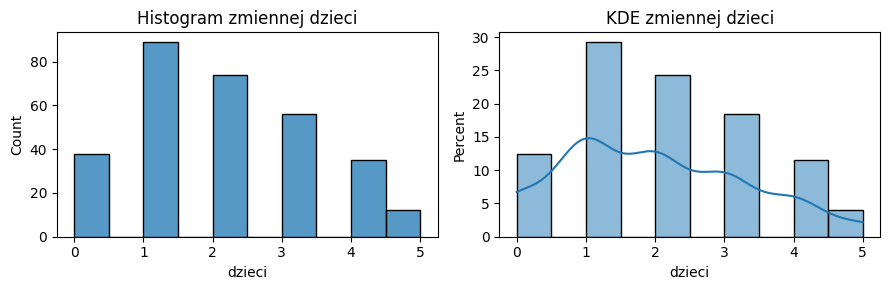

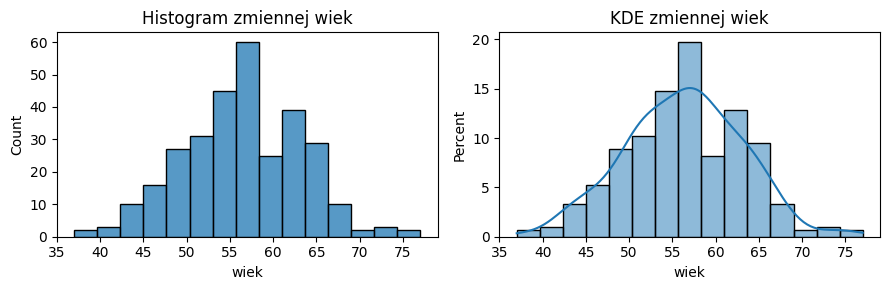

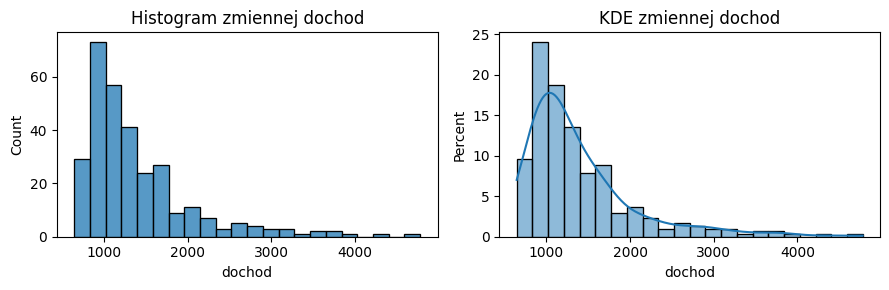

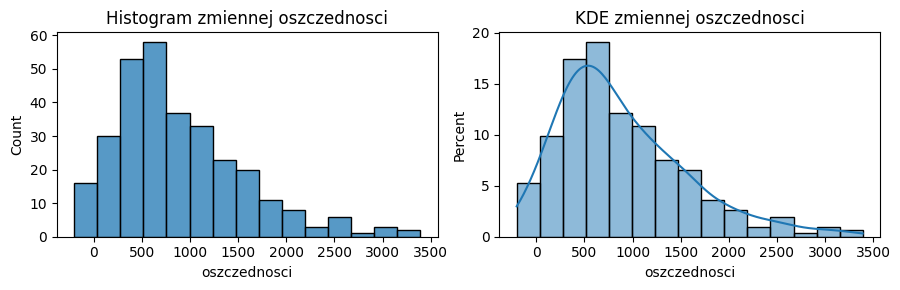

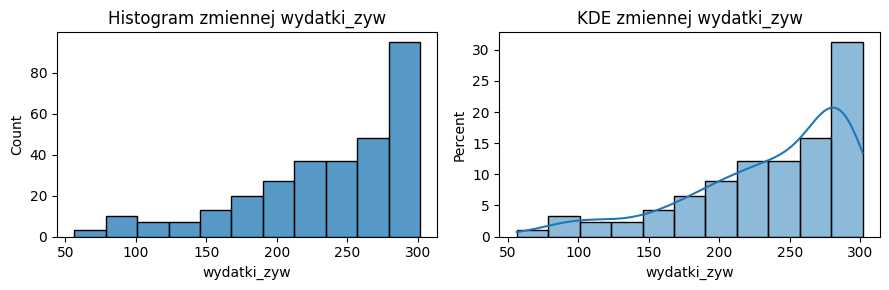

In [4]:
all_vars = categorical_vars + numeric_vars

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, var in enumerate(categorical_vars):
    sns.countplot(x=var, data=data, ax=axes[i])
    axes[i].set_title(f'Histogram zmiennej {var}')
plt.tight_layout()
plt.show()

for var in numeric_vars:
    fig, axes = plt.subplots(1, 2, figsize=(9, 3))
    sns.histplot(data[var], kde=False, ax=axes[0]) 
    axes[0].set_title(f'Histogram zmiennej {var}')

    sns.histplot(data[var], kde=True, stat='percent', ax=axes[1])
    axes[1].set_title(f'KDE zmiennej {var}')

    plt.tight_layout()
    plt.show()

### 1.3
Sporo już powiedzieliśmy w podpunkcie 1.2b, waga, wzrost, liczba dzieci i wiek mają rozkłady zbliżone do rozkładu normalnego. Miejsce jest zmienną jakościową, lecz w takowym grupowaniu również wygląda ja rozkład normalny.

Dochód i oszczędności mają rozkłady prawoskośne, co oznacza, że wartości skupiają się wokół wartości średniej, a wartości odstające znajdują się po prawej stronie rozkładu. Rozkład wydatków na żywność jest rozkładem lewostronnie skośnym, co oznacza, że wartości skupiają się wokół wartości średniej, a wartości odstające znajdują się po lewej stronie rozkładu. 
Ponadto w wydatkach żywnościowych można zobaczyć podobieństwo do rozkładu wykładniczego, dalej podobnie mamy dochód, który przechodzi z wykładniczego w Poissona i oszędności które przypominają bardziej Poissona.

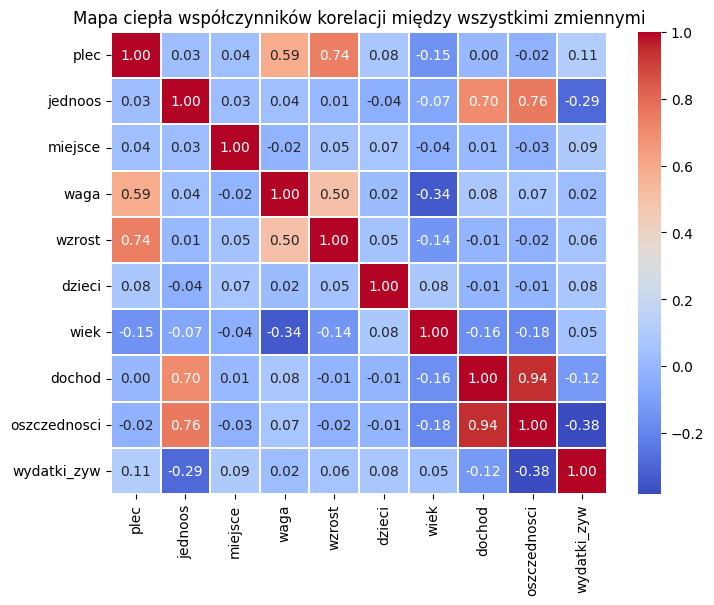

In [5]:
correlation_matrix = data[all_vars].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.1)
plt.title('Mapa ciepła współczynników korelacji między wszystkimi zmiennymi')
plt.show()

### 2a
Zaczniemy od krótkiego wstępu, że analiza korelacji między zmiennymi dostarcza cennych informacji na temat wzajemnych relacji między nimi. Jednakże, samo istnienie korelacji nie oznacza koniecznie istnienia przyczynowości, a także nie uwzględnia innych potencjalnych czynników wpływających na te zależności. Udziela to nam pewnych wskazówek, ale będziemy je starac się wyjaśnić w dalszej analizie. stosując odniesienia do życia codzinnego.

W treści proszono aby na mapie ciepła zaprezentować zasadny współczynnik korelacji pomiędzy zmiennymi ilościowymi, dodaliśmy dodatkowo tam zmienne jakościowe, bo w nich możemy też doszukać się zależności:
- waga i wzrost z płcią (mężczyżni są wyżsi i ciężsi statystycznie, co nie powinno być zaskoczeniem)
- dodatnio dochód i oszczędności (i mniej ale wydatki_zyw ujemnie) z jednoos (rodzajem gospodarstwa domowego) - tu też dość naturalne jednoosobowe gospodarstwa mniej wydają na żywność, co daje im większe oszczędności, natomiast zaskoczeniem może wydawać się fakt, że mają też statystycznie wyższe dochody, być może nie chcą wchodzić w związki i dzielić się majątkiem, skupieni na karierze, bądź przyjaźniejsza światu interpretacja, że nie są na emeryturze i stąd wyzszy dochód, lecz ta ma małe szanse patrząc na dość niską korelację wieku z jednoos.

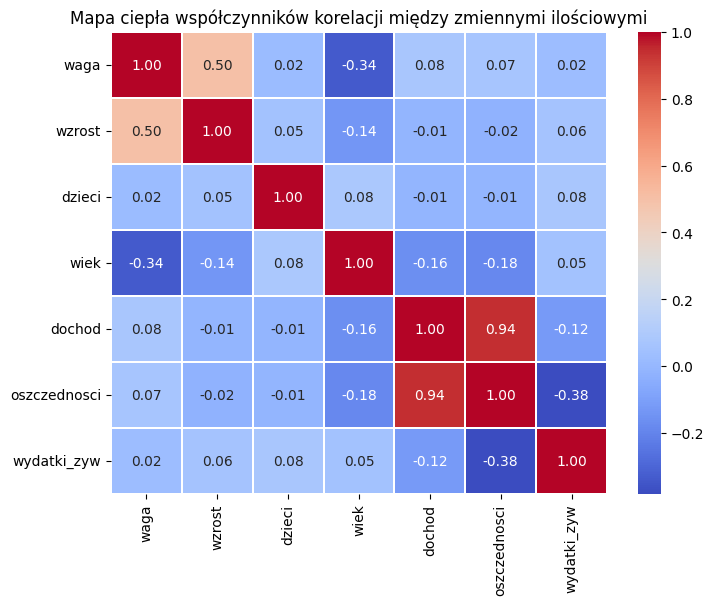

In [6]:
correlation_matrix = data[numeric_vars].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.1)
plt.title('Mapa ciepła współczynników korelacji między zmiennymi ilościowymi')
plt.show()

### 2b
Jeszcze raz mapa tym razem tylko dla zmiennych ilościowych w celu czytelności.

Wartości współczynnika korelacji Pearsona między zmiennymi ilościowymi wskazują na pewne związki:
- Waga i wzrost mają dodatnią korelację o wartości 0.50, co potwierdza, że osoby o większej wadze mają tendencję do większego wzrostu.
- Waga i wiek mają ujemną korelację o wartości -0.34, co sugeruje, że osoby starsze raczej ważą mniej, w świecie jest to potwierdzone spadkiem wzrostu choc tu ta korelacja nie jest tak silna. Być może już maja więcej czasu na aktywność i jedzenie się znudziło.
- Dochód i oszczędności mają silną dodatnią korelację o wartości 0.94, co potwierdza prostą intuicję, że jak się zarabia więcej i nie wydaje wszystkiego to zostaje więcej na oszczędności.
- Wydatki na żywność są ujemnie skorelowane z oszczędnościami (korelacja -0.38), na pierwszy rzut oka mogłoby wydawać się to dziwne, ktoś kto zarabia więcej powinien mieć większe oszczędności i móc pozwolic sobie na większe wydatki na żywność. Natomiast po zastanowieniu się i zauważeniu braku silnej zależności między dochodem a wydatkami na żywność, a wręcz ujemnej korelacji (-0.12) możemy wnioskować, że oszczędności też są większe jak nie wydajemy na żywność.


In [7]:
pairs = list(itertools.combinations(categorical_vars, 2))
for pair in pairs:
    var1, var2 = pair
    contingency_table = pd.crosstab(data[var1], data[var2])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f'Zależność między {var1} a {var2}: p-wartość = {p}')


Zależność między plec a jednoos: p-wartość = 0.7098649541109077
Zależność między plec a miejsce: p-wartość = 0.22342423171950018
Zależność między jednoos a miejsce: p-wartość = 0.7695667530897057


### 2c
Wartość p dla każdej pary zmiennych jest wysoka (powyżej 0.2), zatem test chi kwadrat nie wykazał zależności między zmiennymi jakościowymi.

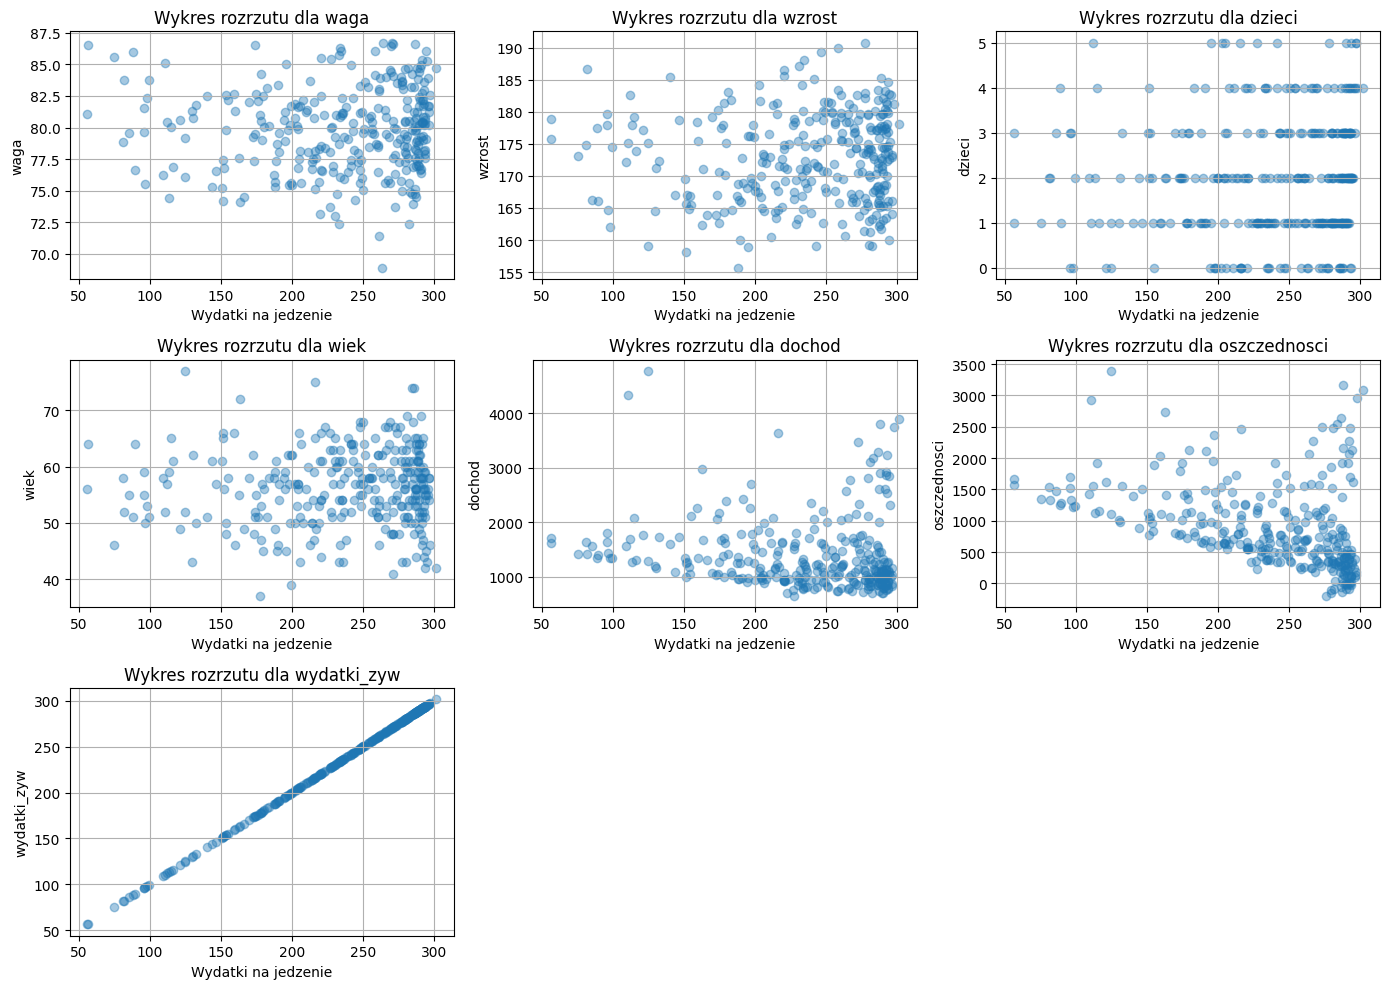

In [8]:
# Wykresy rozrzutu dla wszystkich zmiennych ilościowych względem 'wydatki_zyw'
plt.figure(figsize=(14, 10))

for i, var in enumerate(numeric_vars, start=1):
    plt.subplot(3, 3, i)
    plt.scatter(data['wydatki_zyw'], data[var], alpha=0.4)
    plt.title(f'Wykres rozrzutu dla {var}')
    plt.xlabel('Wydatki na jedzenie')
    plt.ylabel(f'{var}')
    plt.grid(True)

plt.tight_layout()
plt.show()

### 3.1a
Powyżej znajdują się wykresy rozrzuty dla wszystkich zmiennych ilościowych względem wydatki_zyw. Widzimy, że ilość wartości robi się bardzo gęsta w okolicach 280. Szczególną uwagę przyciągją wykresy dla dochodu i oszczędności, gdzie gdzie odpowiednio dla dochodu około 1000 (800-1200) i oszczędności około 300 (200-500) są najgęstsze przy wydatkach na poziomie 280. Taka korelacja wychodziła nam też na heatmap.
Jeszcze sprawdzimy czy to nie jest spowodowane tym że po prostu najwięcej ludzi ma takie dochody i oszcędności.

In [9]:
dochod_800_1200 = data[(data['dochod'] >= 800) & (data['dochod'] <= 1200)].shape[0] / data.shape[0] * 100
print(f'Procent rekordów, dla których dochód mieści się w przedziale 800-1200: {dochod_800_1200:.2f}%')
oszczednosci_200_500 = data[(data['oszczednosci'] >= 200) & (data['oszczednosci'] <= 500)].shape[0] / data.shape[0] * 100
print(f'Procent rekordów, dla których oszczędności mieści się w przedziale 200-500: {oszczednosci_200_500:.2f}%')

Procent rekordów, dla których dochód mieści się w przedziale 800-1200: 44.41%
Procent rekordów, dla których oszczędności mieści się w przedziale 200-500: 21.38%


### 3.1b 
O ile korelacja z dochodem może być mylna przez nagromadzenie aż 44.41% wartości w okolicach 1000, to dla oszczędności jest to tylko 21.38% wartości w okolicach 300. Utwierdza nas to w przekonaniu że osczędności są odwrotnie proporcjonalne do wydatków na żywność. Potencjalny powód już omawialiśmy w 2b.

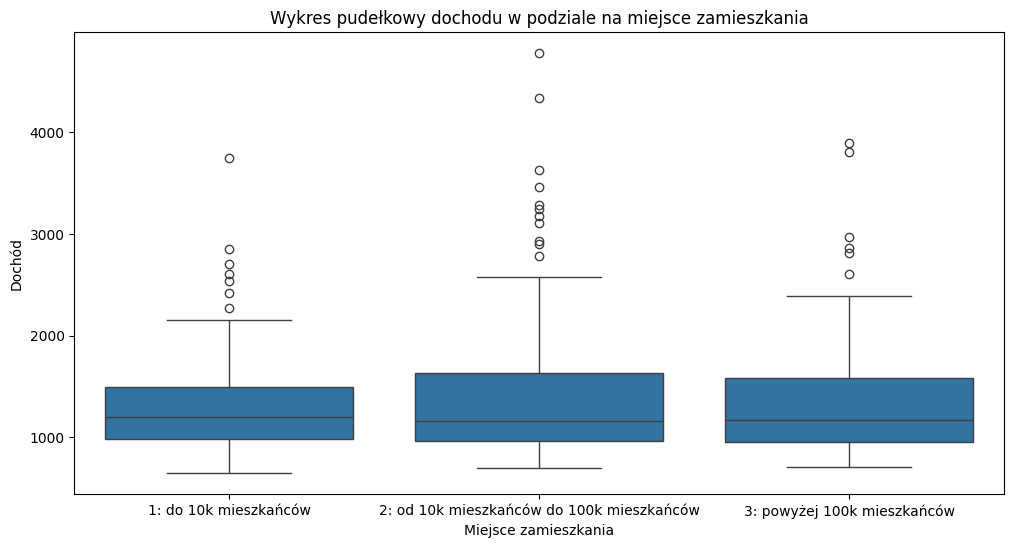

In [10]:
# Wykres pudełkowy dla zmiennej 'dochod' w podziale na miejsce zamieszkania
place_labels = {
    1: "1: do 10k mieszkańców",
    2: "2: od 10k mieszkańców do 100k mieszkańców",
    3: "3: powyżej 100k mieszkańców"
}

plt.figure(figsize=(12, 6))
sns.boxplot(x='miejsce', y='dochod', data=data)
plt.xticks(ticks=[0, 1, 2], labels=[place_labels[i] for i in range(1, 4)])
plt.title('Wykres pudełkowy dochodu w podziale na miejsce zamieszkania')
plt.xlabel('Miejsce zamieszkania')
plt.ylabel('Dochód')
plt.show()


### 3.2
Na wykresie pudełkowym możemy zobaczyć, że dla każdej grupy miast (podzielonych co do wielkości) dochody mają praktycznie identyczną średnią i dość podobne zakresy. Ciekaw może być fakt, że najwyższe wartości dostrzegamy nie dla dużych lecz średnich miast z drugiej kategorii. Można to tłumaczyć tym, że bogatsi np mają pracę zdalną, bądź własne firmy i uciekają od zgiełku metropolii czy braku atrakcji wsi do miast średniej wielkości.

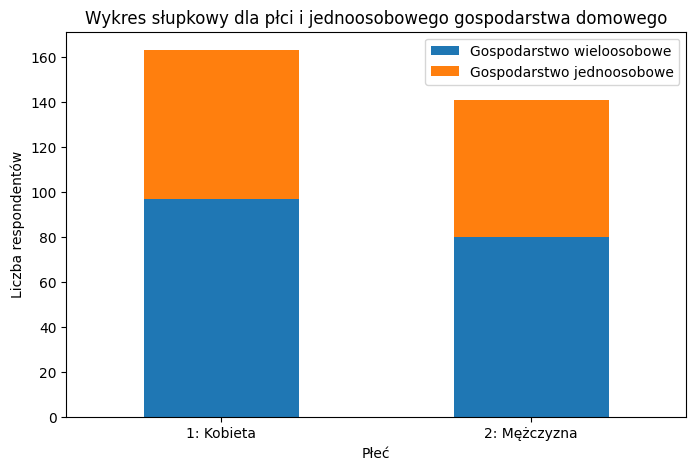

In [11]:
# Wykres słupkowy skumulowany dla płci respondenta i faktu prowadzenia jednoosobowego gospodarstwa domowego
gender_one_person = pd.crosstab(data['plec'], data['jednoos'])

gender_one_person.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Wykres słupkowy dla płci i jednoosobowego gospodarstwa domowego')
plt.xlabel('Płeć')
plt.ylabel('Liczba respondentów')
plt.xticks([0, 1], ['1: Kobieta', '2: Mężczyzna'], rotation=0)
plt.legend(['Gospodarstwo wieloosobowe', 'Gospodarstwo jednoosobowe'])
plt.show()


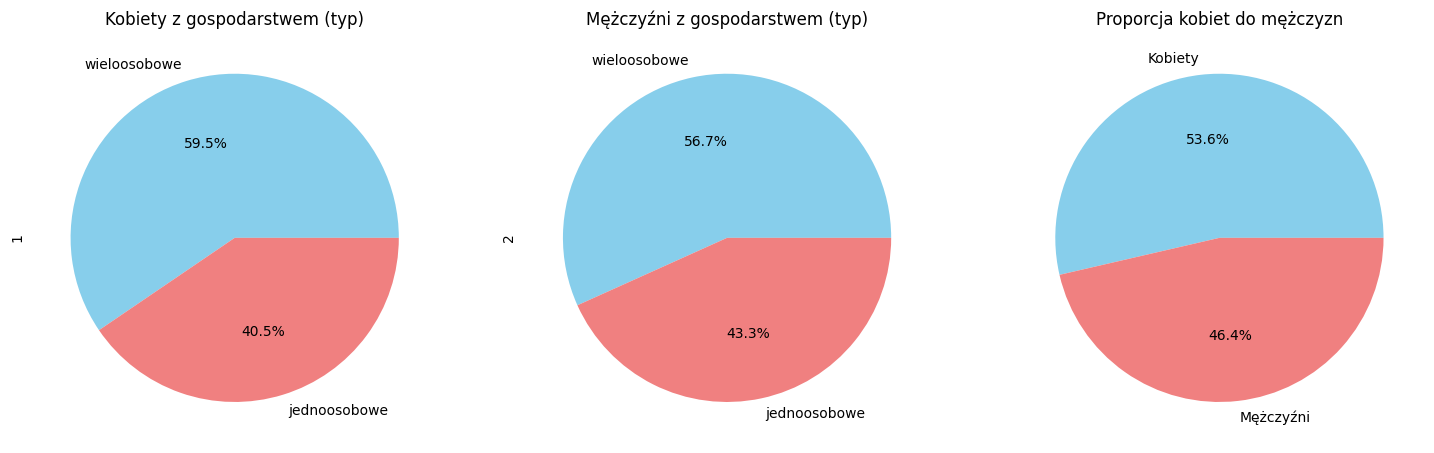

In [12]:
gender_one_person = pd.crosstab(data['plec'], data['jednoos'])
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

labels = ['wieloosobowe', 'jednoosobowe']
gender_one_person.loc[1].plot(kind='pie', labels=labels, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], ax=axes[0])
axes[0].set_title('Kobiety z gospodarstwem (typ)')

gender_one_person.loc[2].plot(kind='pie', labels=labels, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], ax=axes[1])
axes[1].set_title('Mężczyźni z gospodarstwem (typ)')

gender_ratio = [data[data['plec'] == 1].shape[0], data[data['plec'] == 2].shape[0]]
labels = ['Kobiety', 'Mężczyźni']
axes[2].pie(gender_ratio, labels=labels, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
axes[2].set_title('Proporcja kobiet do mężczyzn')
plt.show()


### 3.3
Zalecany w treści wykres słupkowy nie był w pełni czytelny, dodaliśmy 3 wykresy kołowe. Teraz zauważamy, że z danych wynika, że więcej kobiet ma gospodarstwo wieloosobowe (59.5%, w porównaniu z 56.7% u mężczyzn). Jest to zaskakujące, bo kobiet mamy więcej, zatem Panom powinno być prościej znaleźć partnerkę. Kolejna rzecz co się rzuca w oczy to, że ponad 40% ankietowanych prowadzi gospodarstwo jednoosobowe, co jest dość dużym odsetkiem, szczególnie że ankietowani są od 37 roku życia w górę. Być może wynika to z faktu, że ludzi w starszym wieku się rozeszli, bądź potracili partnerów, a ich dzieci już wyprowadziły się z domu.

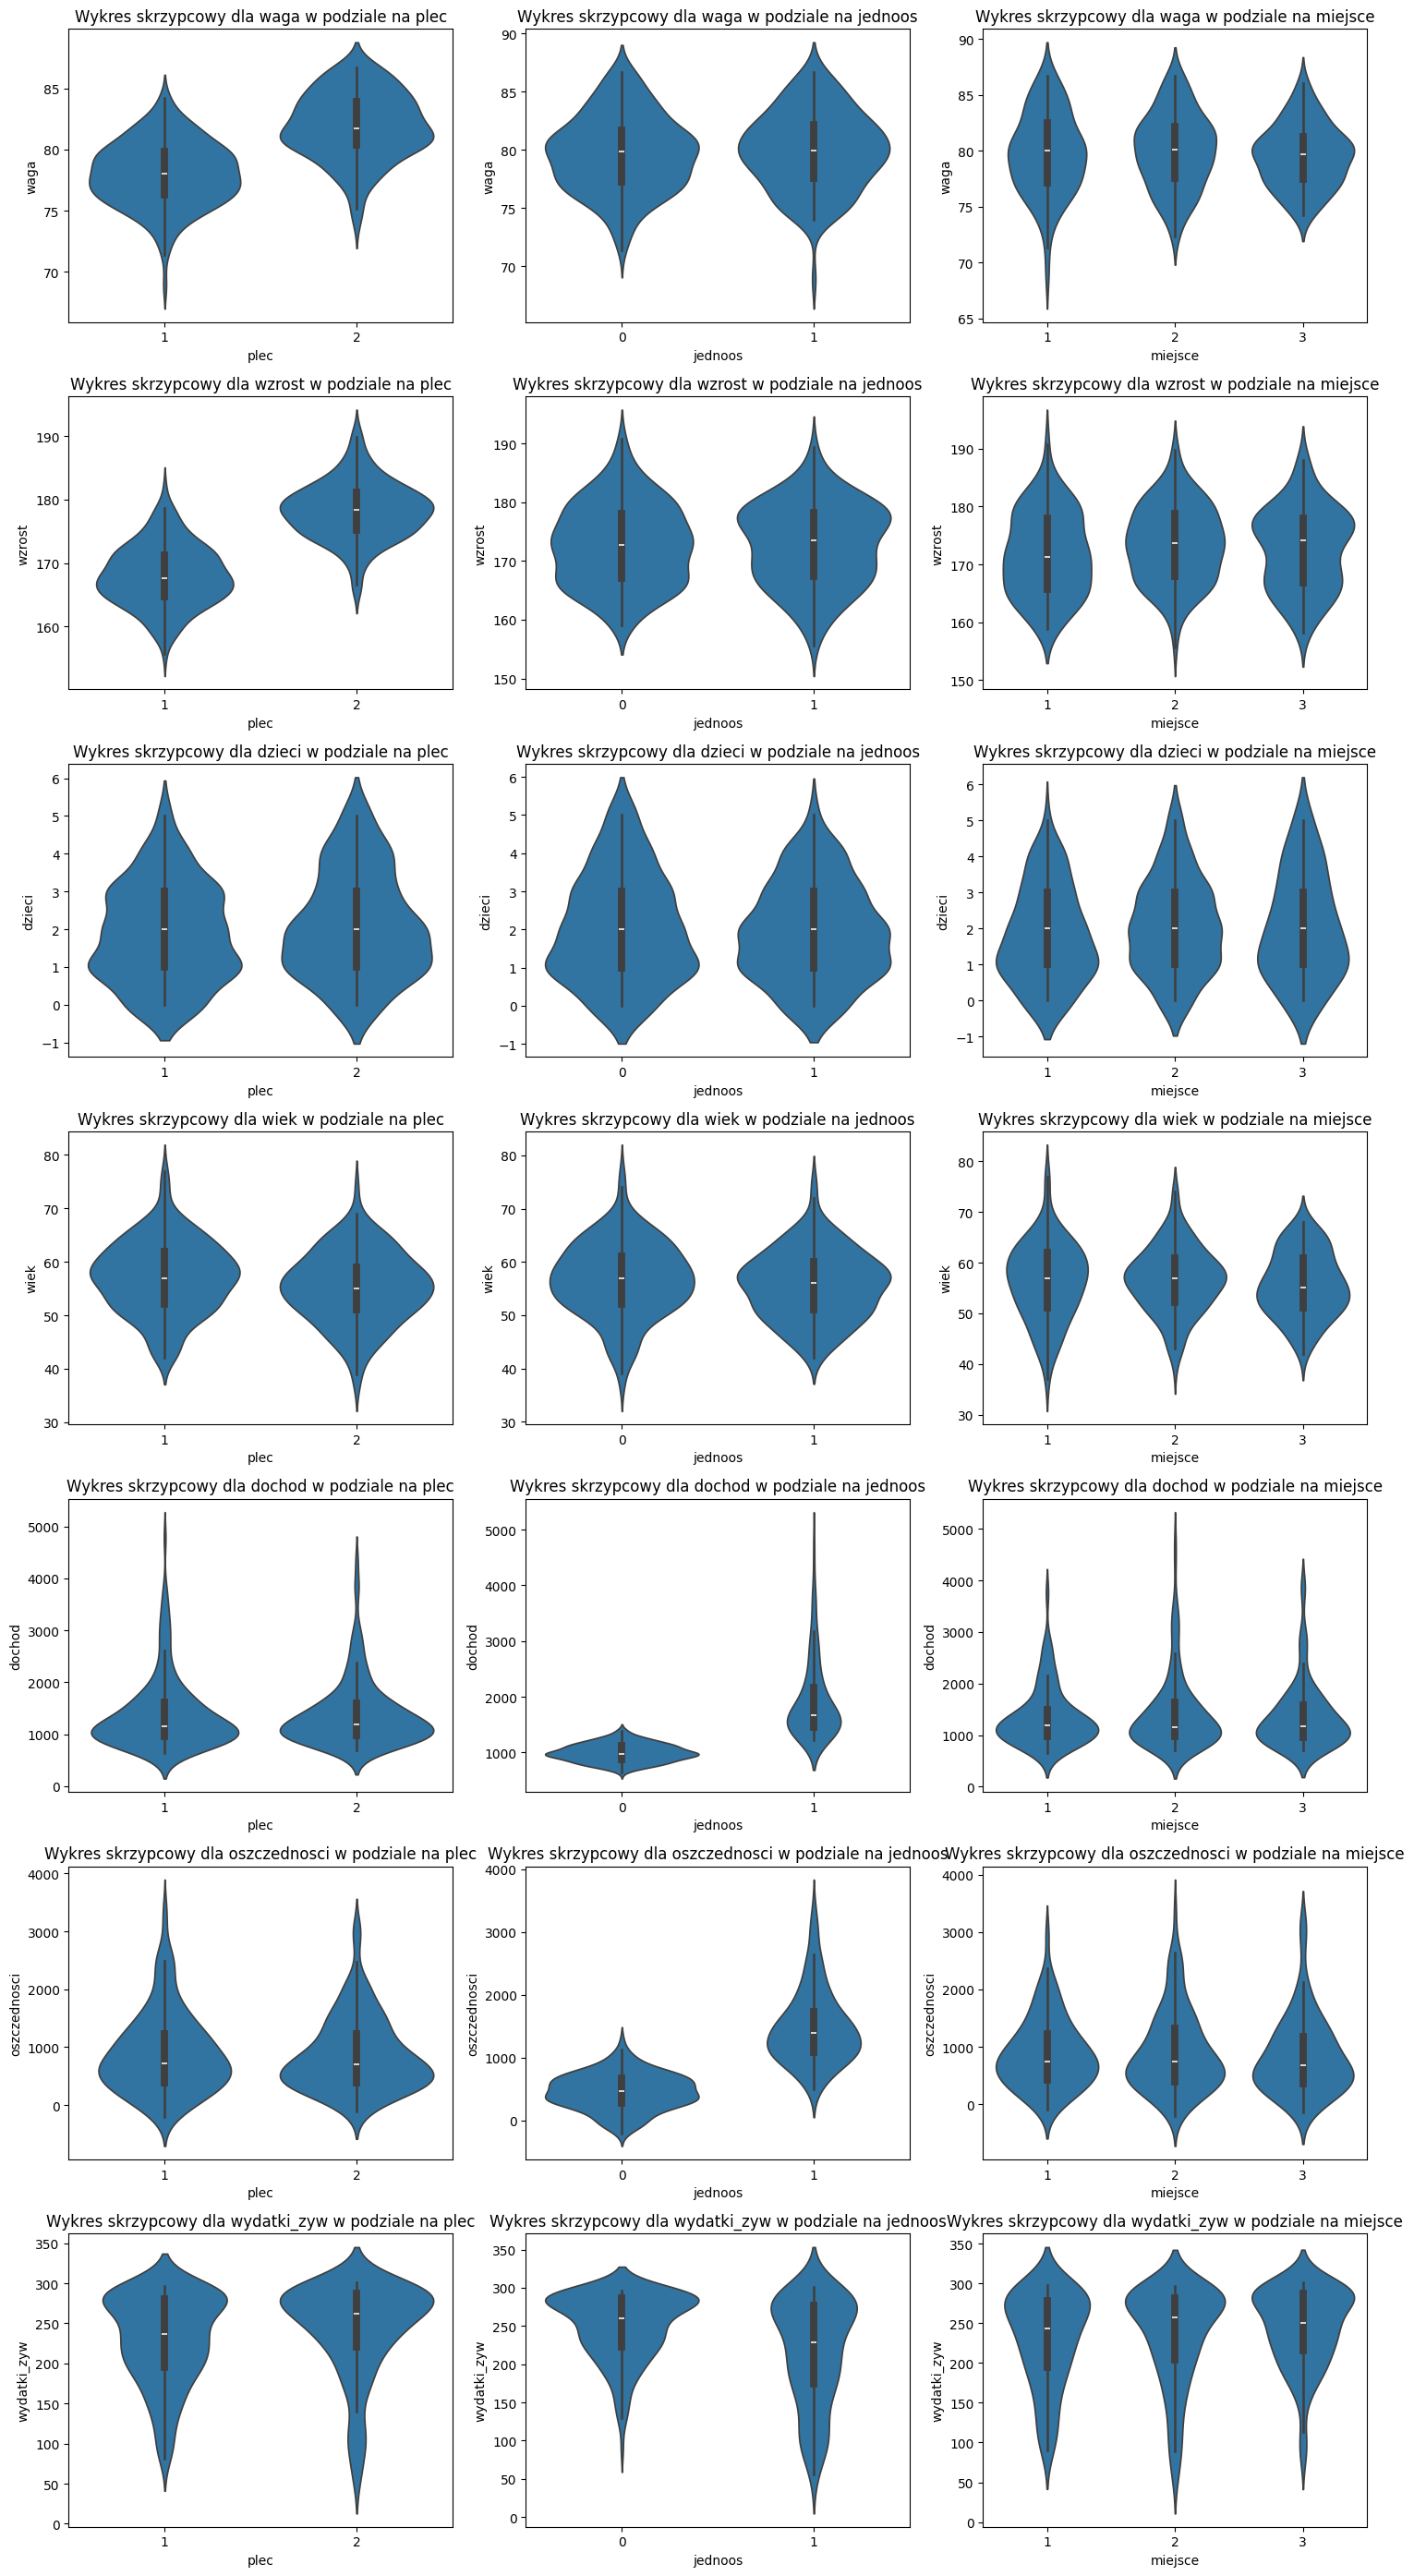

In [13]:
fig, axes = plt.subplots(len(numeric_vars), len(categorical_vars), figsize=(15, 4 * len(numeric_vars)))

# Wykresy skrzypcowe dla zmiennych numerycznych w podziale na zmienne jakościowe
for i, num_var in enumerate(numeric_vars):
    for j, cat_var in enumerate(categorical_vars):
        sns.violinplot(x=data[cat_var], y=data[num_var], ax=axes[i, j])
        axes[i, j].set_title(f'Wykres skrzypcowy dla {num_var} w podziale na {cat_var}')

plt.tight_layout()
plt.show()

### *3.4
Oczywiście chcemy jak najbardziej przeanalizować dane i zdobyć ten dodatkowy punkt tutaj, zatem dla każdej zmiennej ilościowej tworzymy wykres skrzypcowy w połączeniu z każdą zmienną jakościową. Oprócz pięknych widoków możemy zauważyć kilka ciekawych rzeczy:
- Waga i wzrost w podziale na płeć wygląda tak samo dla Kobiet i Mężczyzn, jeśli uwzględnimy odpowiednie przesunięcie (+ kilka kg/cm dla panów).
- Im większe miasto tym mniej niedożywionych osób.
- Rozkład dzieci wygląda na identyczny w rozbicu na każdą zmienną jakościową.
- Im mniejsze miasto tym bardziej skrajne długości życia (szybka śmierć i długowieczność występuje na wsiach).
- Dochody i osczędności w wieloosobowych gospodarstwach domowych są skromne w porównaniu z jednoosobowymi, co może nakłaniać do refleksji, że stabilość rodzinna w życiu daje poczujcie komforyu, jednocześnie ograniczając rozwój i potencjał danej osoby.
- Skrzyżowanie dochoód i oszczędności z pozostałymi zmiennymi jakościowymi prezentuje podobne rozkłady.
- Wydatki na żywność są największe w gospodarstwach wieloosobowych, co niczym nie zadziwia, bo więcej osób = więcej jedzenia.
  
#### Mam nadzieję, że ta dodatkowa analiza spełniła oczekiwania i dostarczyła cennych informacji.

In [14]:
data['wiek'].describe()

count    304.000000
mean      56.259868
std        6.782444
min       37.000000
25%       51.750000
50%       56.500000
75%       61.000000
max       77.000000
Name: wiek, dtype: float64

In [15]:
mean_wiek = data['wiek'].mean()
std_dev_wiek = data['wiek'].std()
confidence_level = 0.99
alpha = 1 - confidence_level

z_score = norm.ppf(1 - alpha/2)
margin_of_error_wiek = z_score * (std_dev_wiek / np.sqrt(len(data)))
confidence_interval_wiek = (mean_wiek - margin_of_error_wiek, mean_wiek + margin_of_error_wiek)
print("Interwał ufności 99% dla średniej wieku (oparty na średniej i odchyleniu standardowym):", confidence_interval_wiek)

degrees_of_freedom = len(data['wiek']) - 1
lower_bound = np.sqrt((degrees_of_freedom * std_dev_wiek**2) / stats.chi2.ppf(1 - alpha/2, degrees_of_freedom))
upper_bound = np.sqrt((degrees_of_freedom * std_dev_wiek**2) / stats.chi2.ppf(alpha/2, degrees_of_freedom))
confidence_interval_std_dev_wiek = (lower_bound, upper_bound)
print("Interwał ufności 99% dla odchylenia standardowego wieku:", confidence_interval_std_dev_wiek)

Interwał ufności 99% dla średniej wieku (oparty na średniej i odchyleniu standardowym): (55.25787116549437, 57.26186567661089)
Interwał ufności 99% dla odchylenia standardowego wieku: (6.136394836972781, 7.568207600724594)


Formuła na przedziały ufności dla kwartyli na podstawie: *http://ndl.ethernet.edu.et/bitstream/123456789/37625/1/William%20Q.%20Meeker_2017.pdf*

In [16]:
len_sqrt = np.sqrt(len(data['wiek']))
for quartile in [0.25, 0.5, 0.75]:
    lower = mean_wiek - stats.t.ppf(1 - alpha / 2, degrees_of_freedom, -len_sqrt * stats.norm.ppf(quartile))*std_dev_wiek/len_sqrt
    upper = mean_wiek - stats.t.ppf(alpha / 2, degrees_of_freedom, -len_sqrt * stats.norm.ppf(quartile))*std_dev_wiek/len_sqrt
    print(f"Interwał ufności 99% dla {quartile} kwantyla wieku: ({lower}, {upper})")

Interwał ufności 99% dla 0.25 kwantyla wieku: (50.67683231064825, 52.69352603166061)
Interwał ufności 99% dla 0.5 kwantyla wieku: (55.25152156054645, 57.26821528155881)
Interwał ufności 99% dla 0.75 kwantyla wieku: (59.82621081044465, 61.84290453145701)


### 4
##### Parametry rozkładu:
- Średnia wieku w populacji wynosi około 56.26 lat.
- Odchylenie standardowe wieku w populacji wynosi około 6.78 lat.
- Pierwszy kwartyl (Q1): 51.75 lat
- Drugi kwartyl (Q2, mediana): 56.50 lat
- Trzeci kwartyl (Q3): 61.00 lat
  
#### Przedziały ufności

##### Dla średniej wieku:
Przedział ufności dla średniej wieku, oparty na średniej i odchyleniu standardowym, wynosi (55.26, 57.26) lat. Oznacza to, że mamy 99% pewność, że prawdziwa średnia wieku populacji mieści się w tym przedziale.
Dla odchylenia standardowego wieku to przedział (6.14, 7.57) lat.

##### Dla kwartyli wieku:
- Przedział ufności dla pierwszego kwartyla (Q1) wynosi (50.68, 52.69) lat.
- Przedział ufności dla drugiego kwartyla (Q2, mediana) wynosi (55.25, 57.29) lat.
- Przedział ufności dla trzeciego kwartyla (Q3) wynosi (59.82, 61.84) lat.

#### Założenia
Aby potwierdzić wiarygodność naszych estymacji, wartow wspomnieć o założeniach, które przyjęliśmy podczas obliczania przedziałów ufności.
Są to losowość i niezależność danych (mamy około 300 obserwacji), a populacja na prawdopodobnie jest większa. Liczymy więc że to co otrzymaliśmy w datasecie rzetelnie zachowuje proporcje w populacji. Ponadto obliczając przedziały uńności zakładaliśmy doczynienie z rozkładem normalnym.
Wyniki jakie otrzymaliśmy w każdym przypadku faktycznie znajdują się dość blisko ale po dwóch różnych stronach wartości faktycznej, co utwierdza nas w przekonaniu że nasze przedziały zostały wyznacone poprawnie.

In [17]:
q25 = data['dochod'].quantile(0.25)
q75 = data['dochod'].quantile(0.75)
q90 = data['dochod'].quantile(0.90)

lower_class = data[data['dochod'] < q25]
middle_class = data[(data['dochod'] >= q25) & (data['dochod'] < q75)]
upper_middle_class = data[(data['dochod'] >= q75) & (data['dochod'] < q90)]
upper_class = data[data['dochod'] >= q90]

In [18]:
classes = {
    "Klasa niższa": lower_class,
    "Klasa średnia": middle_class,
    "Klasa wyższa średnia": upper_middle_class,
    "Klasa wyższa": upper_class
}

averages = {}
std_devs = {}

for class_name, class_data in classes.items():
    avg = class_data['wydatki_zyw'].mean()
    std = class_data['wydatki_zyw'].std()
    averages[class_name] = avg
    std_devs[class_name] = std

print("Średnie wydatki na żywność:")
for class_name, avg in averages.items():
    print(class_name + ":", avg)

print("\nOdchylenia standardowe wydatków na żywność:")
for class_name, std in std_devs.items():
    print(class_name + ":", std)

Średnie wydatki na żywność:
Klasa niższa: 258.6101315789473
Klasa średnia: 231.22664473684208
Klasa wyższa średnia: 201.49044444444448
Klasa wyższa: 249.86258064516124

Odchylenia standardowe wydatków na żywność:
Klasa niższa: 31.333049239566883
Klasa średnia: 59.34493065652634
Klasa wyższa średnia: 65.86981450888065
Klasa wyższa: 56.08326303914814


### 5a
Wyniki są zaskakujące aczkolwiek spójne z naszą wcześniejszą analizą. Najniższa klasa wydaje najwięcej na żywność, zatem nie chodzi tu tylko o to że wydatki ograniczają oszczędności jak wcześniej myśleliśmy, widzimy jeszcze ciekawsze zjawisko, biedni chcą się poczuć bogatsi i wydają na żywność, żeby umilić sobie życie. Klasa średnia i wyższa średnia stają się coraz bardziej świadome swoich finansów i prawdopodobnie oszczędzają na wydatkach. Klasa wyższa natomiast ma już tak dużo pieniędzy, że może sobie pozwolić na wyższe wydatki na żywność. Kolejną rzeczą jest odchylenie standardowe, patrząc na nie widzimy że poza niższą klasą są zarówno jednostki co dużo wydają jak i te oszczędzające. 

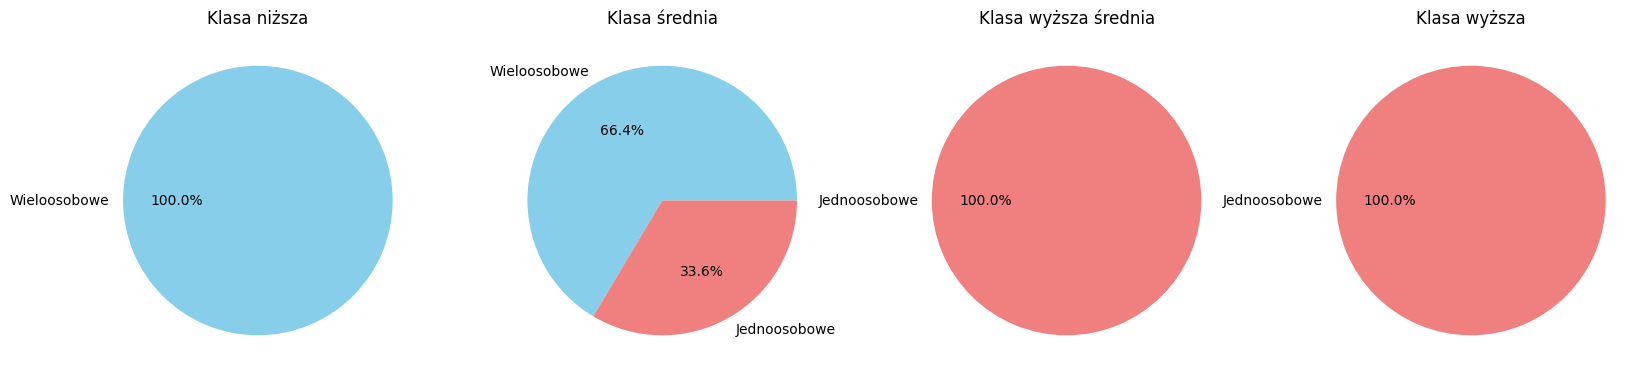

In [19]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, (class_name, class_data) in enumerate(classes.items()):
    household_type_counts = class_data['jednoos'].value_counts()
    if len(household_type_counts) == 1:
        if household_type_counts.index[0] == 0:
            household_type_counts.index = ['0']
            colors = ['skyblue']
            labels = ['Wieloosobowe']
        else:
            household_type_counts.index = ['1']
            colors = ['lightcoral']
            labels = ['Jednoosobowe']
    else:
        household_type_counts.index = ['0', '1']
        colors = ['skyblue', 'lightcoral']
        labels = ['Wieloosobowe', 'Jednoosobowe']

    axes[i].pie(household_type_counts, autopct='%1.1f%%', colors=colors, labels=labels)
    axes[i].set_title(class_name)

plt.show()

### 5b
Nasza analiza byłaby niepełna gdybyśmy jeszcze nie pomyśleli, że wydatki na żywność w nizszej klasie mogą być powodowane innymi czynnikami. Udało nam się znaleźć teraz sensowniejsze wyjaśnienie, mniej dochodowi mieszkańcy mają tendencję do generowania większej ilości dzieci (być może tak poprawiają sobie humor). Oczywiście większe gospodarstwa domowe mają większe wydatki na żywność. Co obserwujemy w klasie niższej i średniej. Teraz odkryliśmy szokującą rzecz, w klasie wyższej średniej i wyższej ludzie są samotni! Być może tylko pracuja i nie mieli czasu w życiu nikogo poznać.

In [20]:
variance_female = np.var(data[data['plec'] == 1]['oszczednosci'])
variance_male = np.var(data[data['plec'] == 2]['oszczednosci'])
print("Wariancja dla kobiet:", variance_female)
print("Wariancja dla mężczyzn:", variance_male)

Wariancja dla kobiet: 481476.8002419888
Wariancja dla mężczyzn: 403906.3103780092


In [21]:
alpha = 0.01
t_stat, p_value = ttest_ind(data[data['plec'] == 1]['oszczednosci'], data[data['plec'] == 2]['oszczednosci'], equal_var=False)

print("Wartość statystyki t:", t_stat)
print("Wartość p:", p_value)

if p_value < alpha:
    print("Odrzucamy hipotezę zerową. Istnieje istotna różnica między średnimi wartościami oszczędności kobiet i mężczyzn.")
else:
    print("Nie ma podstaw do odrzucenia hipotezy zerowej. Nie ma istotnej różnicy między średnimi wartościami oszczędności kobiet i mężczyzn.")


Wartość statystyki t: 0.4306718282065775
Wartość p: 0.6670152475895371
Nie ma podstaw do odrzucenia hipotezy zerowej. Nie ma istotnej różnicy między średnimi wartościami oszczędności kobiet i mężczyzn.


### 6.1 
##### Hipoteza zerowo i alternatywna są czytelne wewnątrz printa, ale zgodnie z poleceniem zadania bedziemy powtarzać je tutaj (aby nie trzeba było szukać w kodzie):

Hipoteza zerowa: Nie ma istotnej różnicy między średnimi wartościami oszczędności kobiet i mężczyzn.

Hipoteza alternatywna: Istnieje istotna różnica między średnimi wartościami oszczędności kobiet i mężczyzn.

Najpierw policzyliśmy wariancje oszczędności dla kobiet i mężczyzn. Wykonując `ttest_ind` dodaliśmy parametr `equal_var=False`, ponieważ wariancje dla obu grup są różne. Otrzymaliśmy wartość p > 0.6, co oznacza, że nie znalaźliśmy istotnych różnic w oszczędnościach między kobietami i mężczyznami. W sumie w zadaniu `3.4` przy wykresie skrzypcowym to już widzieliśmy.

In [22]:
corr_coef, p_value = stats.pearsonr(data['wydatki_zyw'] / data['dochod'], data['oszczednosci'])

print("Współczynnik korelacji Pearsona:", corr_coef)
print("Wartość p:", p_value)

if p_value < alpha:
    print("Odrzucamy hipotezę zerową. Istnieje istotna zależność między proporcją wydatków na żywność względem dochodu a oszczędnościami.")
else:
    print("Nie ma podstaw do odrzucenia hipotezy zerowej. Nie ma istotnej zależności między proporcją wydatków na żywność względem dochodu a oszczędnościami.")

Współczynnik korelacji Pearsona: -0.8882493471959099
Wartość p: 4.823720622545201e-104
Odrzucamy hipotezę zerową. Istnieje istotna zależność między proporcją wydatków na żywność względem dochodu a oszczędnościami.


In [23]:
corr_coef, p_value = stats.pearsonr(data['dochod'] / data['wydatki_zyw'], data['oszczednosci'])
print("Dla odwrotnego ratio oczekujemy teraz dodatniego wysokiego wskaźnika skorelowania")
print("Współczynnik korelacji Pearsona:", corr_coef)
print("Wartość p:", p_value)

Dla odwrotnego ratio oczekujemy teraz dodatniego wysokiego wskaźnika skorelowania
Współczynnik korelacji Pearsona: 0.782702756951558
Wartość p: 3.7599969923153806e-64


### 6.2
Hipoteza zerowa: Nie ma istotnej różnicy między proporcją wydatków na żywność względem dochodu a oszczędnościami.

Hipoteza alternatywna: Istnieje istotna zależność między proporcją wydatków na żywność względem dochodu a oszczędnościami.

Policzyliśmy to na dwa sposoby, najpierw faktycznie biorąc proporcję wydatków na żywność względem dochodu a potem jej odwrotność. W obu przypadkach p było bardzo małe a współczynnik korelacji Pearsona wysoki (ujemnie skorelowany odpowiadając na postawiony problem), co oznacza, że niższa proporcja wydatków na żywność względem dochodu jest skorelowana z wyższymi oszczędnościami. To zresztą już też wcześniej poruszaliśmy w `3` i `5` analizując, że najwyższe wydatki na żywność były w grupach o najniższych dochodach, a te z kolei miały najniższe oszczędności.

In [24]:
print("Średnia waga kobiet w próbie:", data[data['plec'] == 1]['waga'].mean())
t_stat, p_value = stats.ttest_1samp(data[data['plec'] == 1]['waga'], 56)

print("Wartość statystyki t:", t_stat)
print("Wartość p:", p_value)

if p_value < alpha:
    print("Odrzucamy hipotezę zerową. Średnia waga kobiet w próbie jest istotnie wyższa niż 56 kg.")
else:
    print("Nie ma podstaw do odrzucenia hipotezy zerowej. Średnia waga kobiet nie jest istotnie wyższa od 56 kg.")

Średnia waga kobiet w próbie: 78.01662576687117
Wartość statystyki t: 107.0286338796581
Wartość p: 3.1422326697265078e-152
Odrzucamy hipotezę zerową. Średnia waga kobiet w próbie jest istotnie wyższa niż 56 kg.


### 6.3
Hipoteza zerowa: Średnia waga kobiet w populacji nie jest istotnie wyższa niż 56 kg.

Hipoteza alternatywna: Średnia waga kobiet w populacji jest istotnie wyższa niż 56 kg.

Wynik testu t-studenta dla średniej wagi kobiet w populacji wykazały, że ta waga jest istotnie wyższa niż 56 kg. Nie będziemy się nad tym zbyt rozwodzić, to oczywiste, w zadaniu `3.4` pokazaliśmy na wykresie jaki ta waga ma rozkład, a sama średnia to około 78kg.

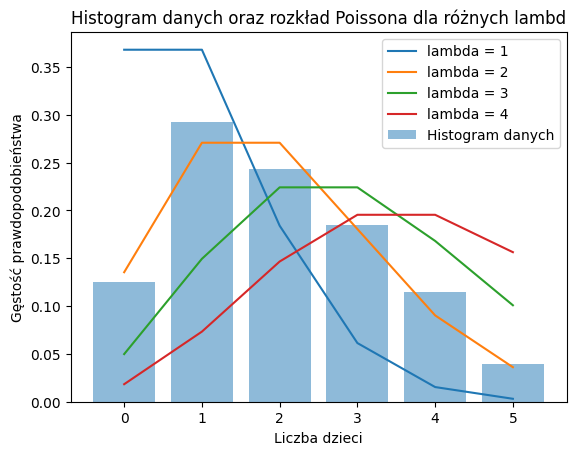

In [25]:
kids = data['dzieci']
hist, bins = np.histogram(kids, bins=range(7), density=True)
lambdas = [1, 2, 3, 4]

for lam in lambdas:
    poisson_vals = [poisson.pmf(i, mu=lam) for i in range(max(kids) + 1)]
    plt.plot(range(len(poisson_vals)), poisson_vals, label=f'lambda = {lam}')

plt.bar(bins[:-1], hist, width=0.8, alpha=0.5, label='Histogram danych')
plt.xlabel('Liczba dzieci')
plt.ylabel('Gęstość prawdopodobieństwa')
plt.title('Histogram danych oraz rozkład Poissona dla różnych lambd')
plt.legend()
plt.show()

In [26]:
ks_stat, p_value = stats.kstest(kids, 'poisson', args=(2,))
print("Wartość statystyki testowej:", ks_stat)
print("P-wartość:", p_value)

if p_value < alpha:
    print("Odrzucamy hipotezę zerową. Zmienna dzieci jest zgodna z rozkładem Poissona (lambda=2).")
else:
    print("Nie ma wystarczających dowodów na odrzucenie hipotezy zerowej. Zmienna dzieci może nie być zgodna z rozkładem Poissona (lambda=2).")

Wartość statystyki testowej: 0.28100584970983794
P-wartość: 1.0019448000405118e-21
Odrzucamy hipotezę zerową. Zmienna dzieci jest zgodna z rozkładem Poissona (lambda=2).


### 6.4
Hipoteza zerowa: Zmienna dzieci może nie być zgodna z rozkładem Poissona (lambda=2).

Hipoteza alternatywna: Zmienna dzieci jest zgodna z rozkładem Poissona (lambda=2).

Zgodnie z sugestią w treści zajeliśmy się podobieństwem do Poissona. Dzieci od razu są podzielone na 6 kategorii, wieć wygerowaliśmy wykres dla różnych lambd. Największe podobieństwo widzimy dla lambda=2, pop przeprowadzeniu testu zgodności Kolmogorova-Smirnova otrzymaliśmy potwierdznie zgodność dzieci z rozkładem Poissona dla lambda=2.

In [27]:
def build_preliminary_model(data, categorical_vars, dependent_var):
    model_data = pd.get_dummies(data, columns=categorical_vars)
    model_data.rename(columns={'plec_1': 'kobieta', 'plec_2': 'mezczyzna', 
                                'jednoos_0': 'gospodarstwo_wieloosobowe', 
                                'jednoos_1': 'gospodarstwo_jednoosobowe', 
                                'miejsce_1': 'do_10k_mieszkancow', 
                                'miejsce_2': 'od_10k_do_100k_mieszkancow', 
                                'miejsce_3': 'powyzej_100k_mieszkancow'}, inplace=True)
    X = model_data.drop(columns=[dependent_var])
    y = model_data[dependent_var].astype(float)
    X = sm.add_constant(X).astype(float)
    preliminary_model = sm.OLS(y, X).fit()
    return y, X, preliminary_model

y, X, preliminary_model = build_preliminary_model(data, categorical_vars, 'wydatki_zyw')
print(preliminary_model.summary())

                            OLS Regression Results                            
Dep. Variable:            wydatki_zyw   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     61.90
Date:                Fri, 10 May 2024   Prob (F-statistic):           2.51e-66
Time:                        16:24:09   Log-Likelihood:                -1488.6
No. Observations:                 304   AIC:                             2999.
Df Residuals:                     293   BIC:                             3040.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### 7a
Wnioski z analizy regresji:

1. Na podstawie R-kwadrat wynosi widzimy, że 67,9% zmienności zmiennej "wydatki_zyw" może być wyjaśnione przez nasz model regresji.

2. Istotne zmienne: Dochód (p < 0,001), Oszczędności (p < 0,001), Liczba dzieci (p = 0,028), Płeć (kobieta: p = 0,010, mężczyzna: p = 0,018), Gospodarstwo (jednoosobowe: p = 0,009, wieloosobowe: p = 0,023) oraz Miejsce zamieszkania (do 10k mieszkańców: p = 0,011, od 10k do 100k mieszkańców: p = 0,033, powyżej 100k mieszkańców: p = 0,010).

3. Najbardziej istotne zmienne to Dochód (t = 21,572) i Oszczędności (t = -22,336), omawialiśmy to bardzo dokładnie w zadaniu 3 i jeszce dokładniej w 5, pisaliśmy też że typ gospodarstwa i ilość dzieci na utrzymaniu oczywiście zwiększają wydatki na żywonść.

4. Warto zauważyć, że istnieje problem silnej multicollinearności (współczynnik korelacji Pearsona między Dochodem a Oszczędnościami wynosi 0,94), co może prowadzić do niestabilności modelu regresji - zadanie `2b`. Tak wyprzedziliśmy trochę, jeszcze do tego wrócimy w `7c`.

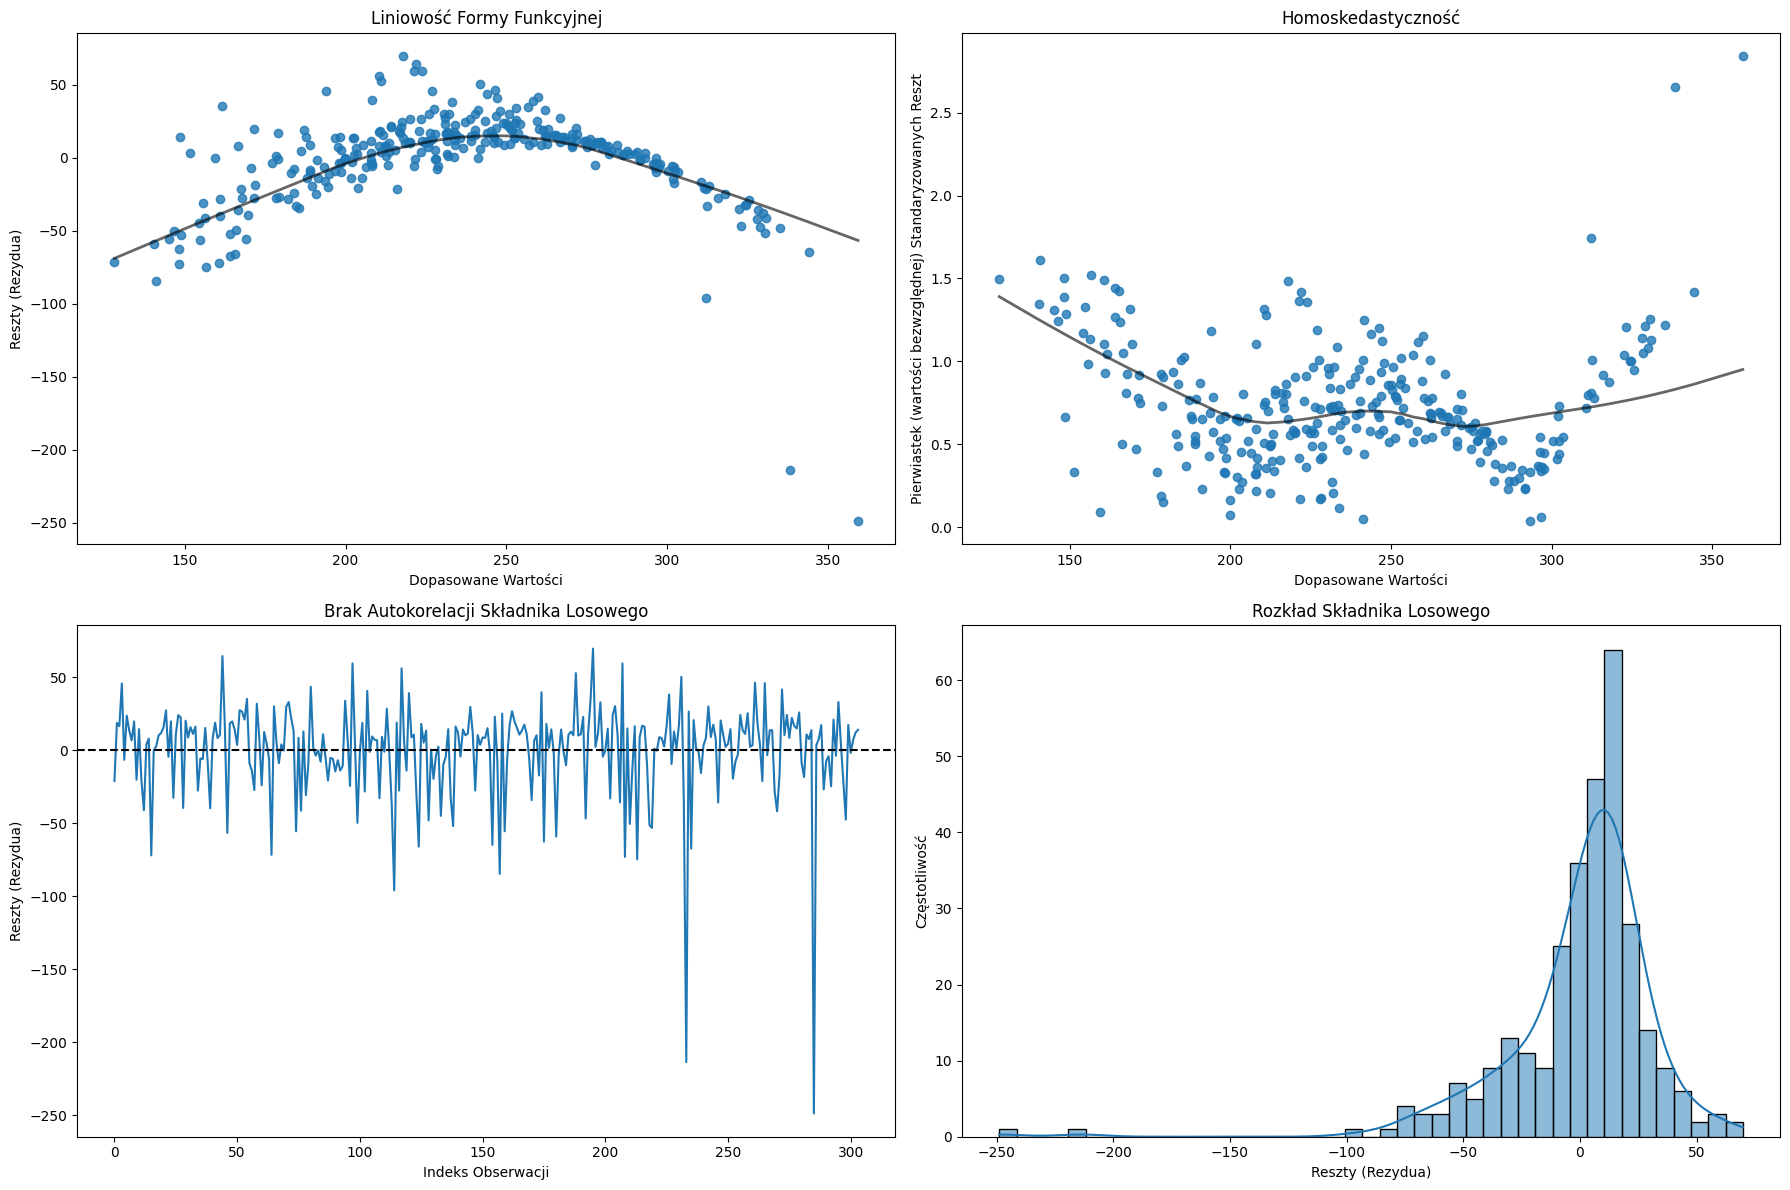

In [28]:
def plot_diagnostic_plots(preliminary_model):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

    sns.regplot(x=preliminary_model.fittedvalues, y=preliminary_model.resid,
                scatter=True, ci=False, lowess=True,
                line_kws={'color': 'black', 'lw': 2, 'alpha': 0.6}, ax=axes[0, 0])
    axes[0, 0].set_title('Liniowość Formy Funkcyjnej')
    axes[0, 0].set_xlabel('Dopasowane Wartości')
    axes[0, 0].set_ylabel('Reszty (Rezydua)')

    sns.regplot(x=preliminary_model.fittedvalues, y=np.sqrt(np.abs(preliminary_model.get_influence().resid_studentized_internal)),
                scatter=True, ci=False, lowess=True,
                line_kws={'color': 'black', 'lw': 2, 'alpha': 0.6}, ax=axes[0, 1])
    axes[0, 1].set_title('Homoskedastyczność')
    axes[0, 1].set_xlabel('Dopasowane Wartości')
    axes[0, 1].set_ylabel('Pierwiastek (wartości bezwzględnej) Standaryzowanych Reszt')

    sns.lineplot(x=range(len(preliminary_model.resid)), y=preliminary_model.resid,
                 linestyle='-', ax=axes[1, 0])
    axes[1, 0].axhline(y=0, color='black', linestyle='--')
    axes[1, 0].set_title('Brak Autokorelacji Składnika Losowego')
    axes[1, 0].set_xlabel('Indeks Obserwacji')
    axes[1, 0].set_ylabel('Reszty (Rezydua)')

    sns.histplot(preliminary_model.resid, kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Rozkład Składnika Losowego')
    axes[1, 1].set_xlabel('Reszty (Rezydua)')
    axes[1, 1].set_ylabel('Częstotliwość')

    plt.tight_layout()
    plt.show()

plot_diagnostic_plots(preliminary_model)

### 7b
Aby sprawdzić czy model spełnia założenia Klasycznego Modelu Regresji Liniowej (KMRL), wykonaliśmy analizę diagnostyczną:
1. **Liniowość formy funkcyjnej**: Zmienna zależna "wydatki_zyw" może być liniowo przewidywana przez pozostałe zmiennne niezależne.
2. **Homoskedastyczność**: Wariancja reszt modelu jest stała dla wszystkich wartości zmiennych niezależnych. W kontekście regresji liniowej, oznacza to, że rozrzut punktów wokół linii regresji powinien być równomierny dla wszystkich wartości zmiennych niezależnych.
3. **Brak autokorelacji składnika losowego**: Reszty modelu są niezależne od siebie, co oznacza brak autokorelacji między nimi.
4. **Rozkład składnika losowego**: Reszty modelu mają rozkład zbliżony do normalnego.

Wnioski z analizy diagnostycznej:
1. Ewidentnie widzimy, że to bardziej parabola niż linia, co wskazuje, że model nie spełnia założenia liniowości formy funkcyjnej.
2. Tu też zauważamy problem, punkty są porozrzucane w różnych miejscach, co skłania do decyzji o braku homoskedastyczności.
3. Reszty modelu są wydają się być niezależne od siebie, co oznacza brak autokorelacji między nimi. Mamy jakieś 2 podejrznie większe odchylenia.
4. Z wykresu widzimy podobną dystrybucję do rozkładu normalnego, nie jest idealna, ale zdecydownie nie razi w oczy, poza lewoskośnością.

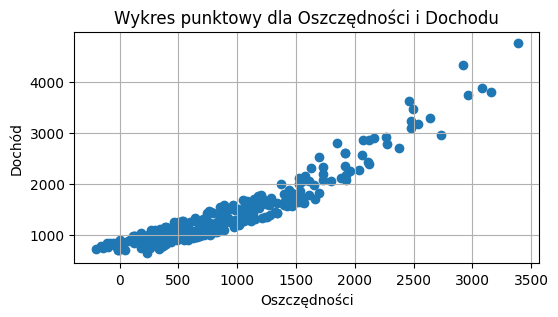

                       Feature        VIF
0                        const   0.000000
1                         waga   1.731495
2                       wzrost   2.248774
3                       dzieci   1.028401
4                         wiek   1.203732
5                       dochod   9.216374
6                 oszczednosci  11.222733
7                      kobieta        inf
8                    mezczyzna        inf
9    gospodarstwo_wieloosobowe        inf
10   gospodarstwo_jednoosobowe        inf
11          do_10k_mieszkancow        inf
12  od_10k_do_100k_mieszkancow        inf
13    powyzej_100k_mieszkancow        inf


/Users/damiad/Desktop/studies/WUM/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/damiad/Desktop/studies/WUM/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [29]:
plt.figure(figsize=(6, 3))
plt.scatter(X['oszczednosci'], X['dochod'])
plt.title('Wykres punktowy dla Oszczędności i Dochodu')
plt.xlabel('Oszczędności')
plt.ylabel('Dochód')
plt.grid(True)
plt.show()

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

### 7c
W sumie już na to odpowiedzieliśmy, ale jak każą drugi raz to się powtórzymy. Zaczynamy od wykresu punktowego dla Oszczędności i Dochodu, widzimy że jest to niemalże linia, co sugeruje że mamy do czynienia z multicollinearity. Następnie sprawdzamy współczynnik VIF dla każdej zmiennej, widzimy że dla Oszczędności i Dochodu osiąga on odpowiednio 11.22 i 9.21, potwierdza to nasze przypuszczenia. Współczynniki VIF powyżej 10 sugerują, że zmienne są skorelowane ze sobą, co może prowadzić do niestabilności modelu regresji.

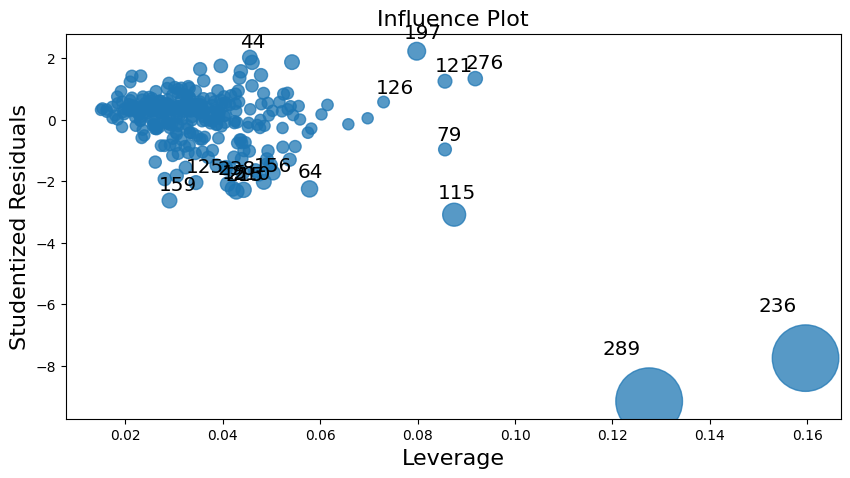

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
sm.graphics.influence_plot(preliminary_model, criterion="cooks", ax=ax)
plt.show()

### 7d 
Korzystając z analizy obserwacji odstających dla wstępnego modelu, sprawdzamy czy baza zawiera błedy. Podejrzane są obserwacje numer 236, 289 oraz 115, są bowiem bardzo odległe i ich rozmiary wyróżniają się wielkością. To tylko 3 rekordy zatem sensowne będzie ich usunięcie, tak jak wcześniej usuwaliśmy rekordy z ujemnymi wydatkami na żywność.

      waga  wzrost  plec  dzieci  wiek   dochod  oszczednosci  jednoos  \
239  81.70  174.57     2       2    57  2863.30       2067.71        1   
294  76.83  166.99     1       3    56  1273.13       1056.88        0   
116  84.05  174.37     2       1    41  1283.67        736.86        0   

     miejsce  wydatki_zyw  
239        3       292.49  
294        1       152.43  
116        1       270.90  


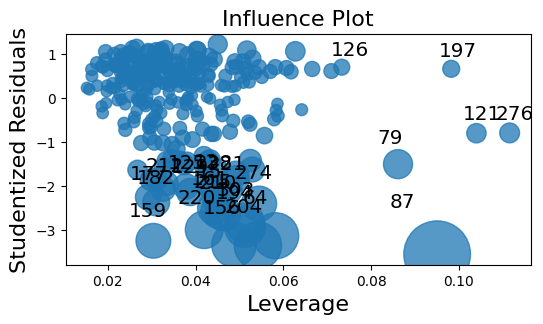

In [31]:
print(data.iloc[[236,289,115]])
data.drop([236,289,115], inplace=True)
y, X, preliminary_model = build_preliminary_model(data, categorical_vars, 'wydatki_zyw')
fig, ax = plt.subplots(figsize=(6, 3))
sm.graphics.influence_plot(preliminary_model, criterion="cooks", ax=ax)
plt.show()

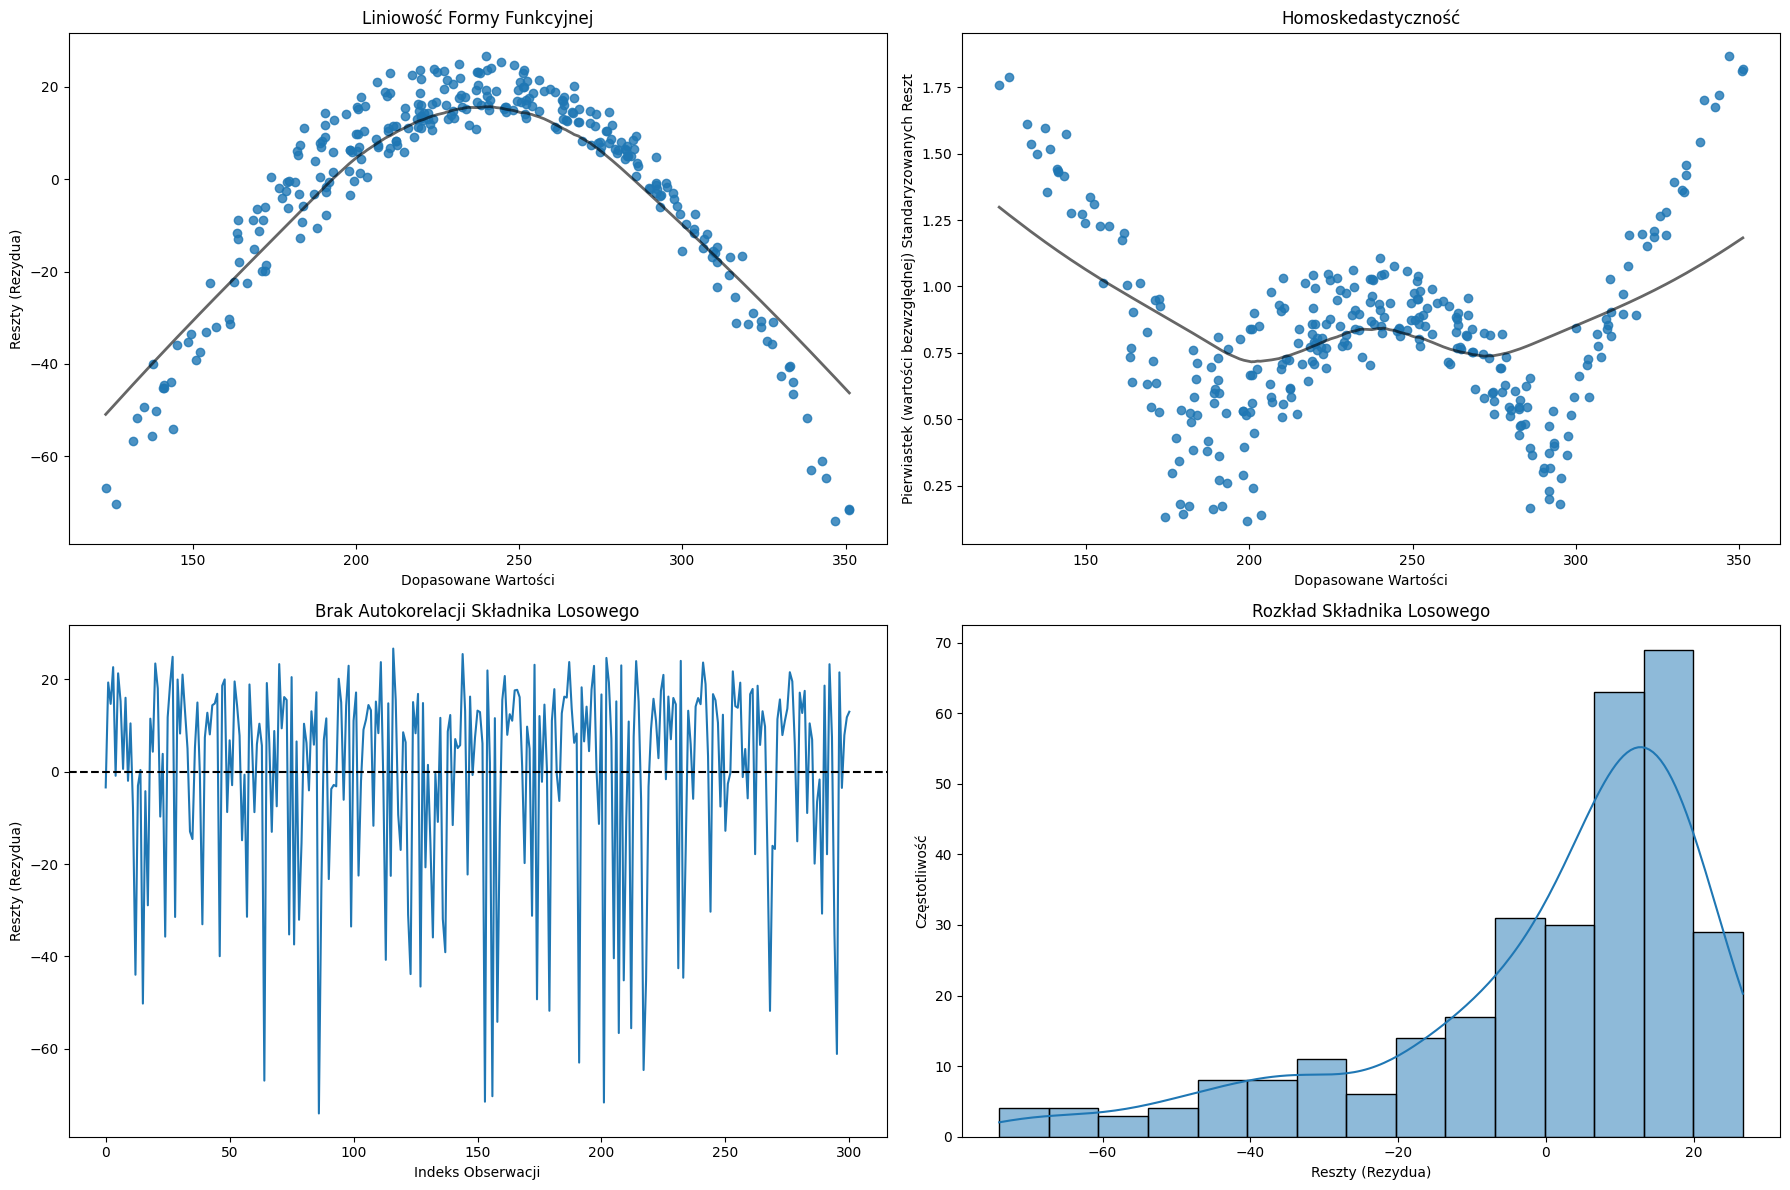

In [32]:
plot_diagnostic_plots(preliminary_model)

### 7e
Po usunięciu podejrzanych obserwacji, znów generujmy wykresy i patrzymy na wykresy.
Szczególną uwagę przyciąga wykres liniowości formy funkcyjnej, oczywiście nie zachwyca liniowością, a bardziej zauważamy funkcję kwadratową. Przypomijmy obserwacje z `7a` gdzie: Dochód (t = 21,572) i Oszczędności (t = -22,336) oraz `7c` o zależności między tymi zmiennymi, możemy się pokusić na wprowadzenie nowej kolumny do modelu, która będzie kwadratem wydatków ogółem. Oczywiście wydatki możemy obliczyć zgodnie z treścią zadania:

 `oszczednosci – deklarowane oszczedności respondenta w badanym miesiącu (w bajtalarach, ujemne wartości oznaczają, że wydatki ogółem przekroczyły dochód)`

Zatem `wydatki_ogolem = dochod - oszczednosci` (bierzemy jeszcze kwadrat tej wartości), aby zagwarantować liniowość formy funkcyjnej.

                            OLS Regression Results                            
Dep. Variable:            wydatki_zyw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.549e+04
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        16:24:10   Log-Likelihood:                -443.38
No. Observations:                 301   AIC:                             910.8
Df Residuals:                     289   BIC:                             955.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

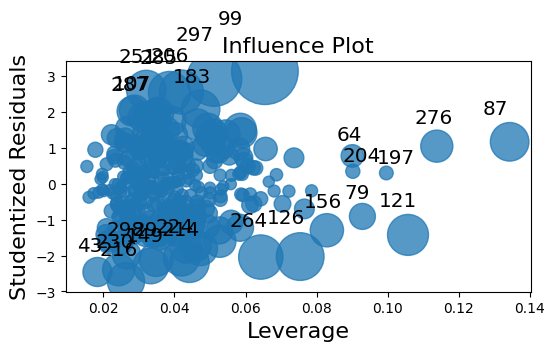

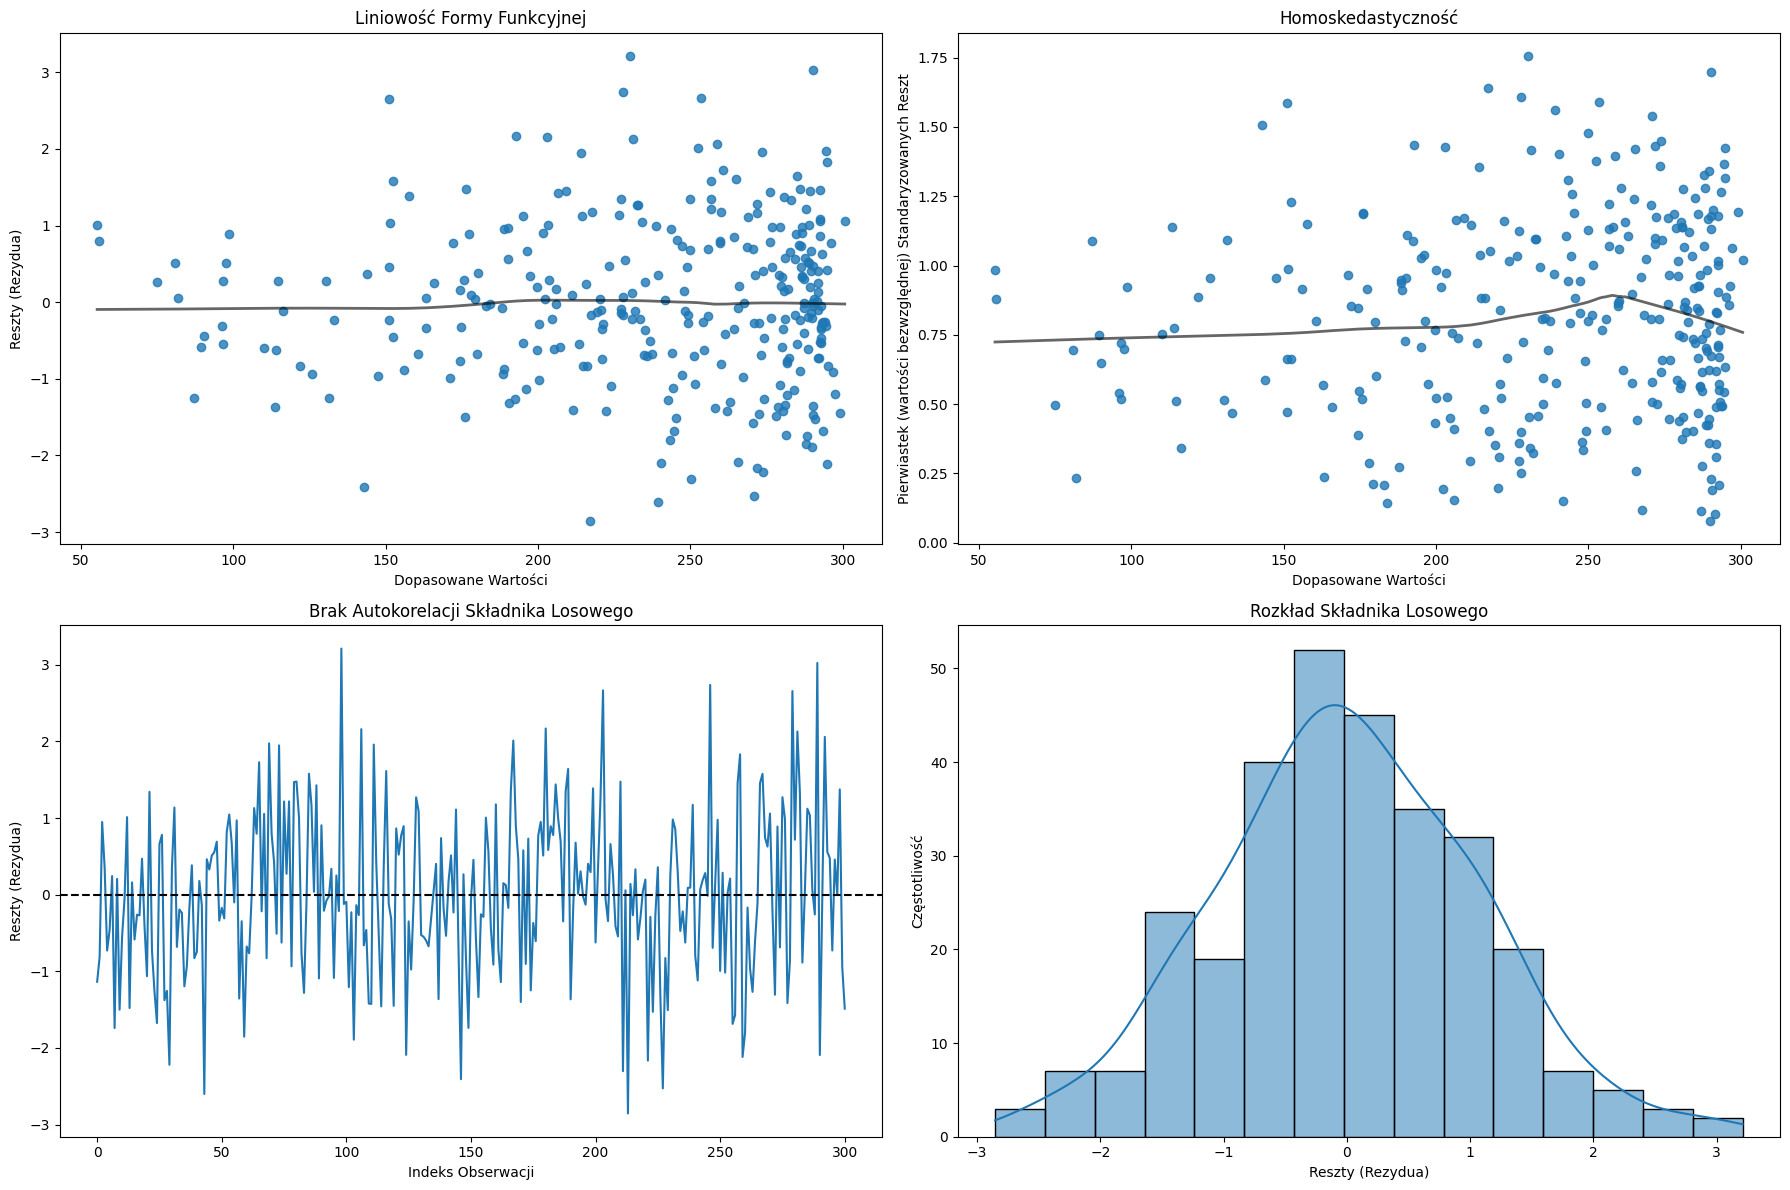

In [33]:
data["kwadrat_wydatkow_ogolem"] = (data["dochod"]- data["oszczednosci"])**2
y, X, preliminary_model = build_preliminary_model(data, categorical_vars, 'wydatki_zyw')
print(preliminary_model.summary())
fig, ax = plt.subplots(figsize=(6, 3))
sm.graphics.influence_plot(preliminary_model, criterion="cooks", ax=ax)
plt.show()
plot_diagnostic_plots(preliminary_model)

### 7f
Otrzymane wyniki cieszą oko.

Wyniki regresji pokazują, że model doskonale pasuje do danych, co potwierdza wartość R-kwadrat wynosząca 1,0. Oznacza to, że 100% zmienności zmiennej objaśnianej (wydatki_zyw) jest wyjaśnione przez nasz model. Dodatkowo, współczynniki p-value dla wagi, dzieci, wiek, dochod, oszczędności oraz kwadrat_wydatkow_ogolem wynoszą są niskie 0.000 (dokładność), co ilustruje istotność tych zmiennych.
Warto znów spojrzeć na:
```
                                 coef    std err          t      P>|t|      [0.025      0.975]
dochod                         0.6983      0.001    526.280      0.000       0.696       0.701
oszczednosci                  -0.6983      0.001   -524.817      0.000      -0.701      -0.696
```
Wyniki współczynników dla zmiennych "dochod" i "oszczednosci" jeszcze bardziej potwierdzają nasze wnioski. Oba współczynniki mają bardzo niskie wartości p-value, co oznacza, że są one istotne statystycznie. Ponadto, oba współczynniki mają bardzo wysokie wartości t-statistic, co sugeruje, że są one znaczące z praktycznego punktu widzenia.

Wartości współczynników dla obu zmiennych są również bardzo bliskie sobie, ale o przeciwnych znakach. To potwierdza, słuszność dodania dodatkowej kolumny.

Wyniki dla innych zmiennych o niskim p-value również warto przeanalizować:

- **waga**: Współczynnik wynosi około 0.3642, co oznacza, że z każdym jednostkowym wzrostem wagi o 1, wydatki na jedzenie wzrastają o średnio 0.3642 jednostki. Zgadza się, że grubsze osoby jedzą więcej, bo mają większe zapotrzebowanie kaloryczne.

- **dzieci**: Współczynnik dla zmiennej dzieci wynosi około 1.5028. Oznacza to, że osoby z dziećmi mają tendencję do większych wydatków na jedzenie. Znów to nie zaskoczenie, trzeba wykarmić rodzinę.

- **wiek**: Współczynnik dla wieku wynosi około -0.2469, co sugeruje, że starsze osoby mają tendencję do mniejszych wydatków na jedzenie. Może to wynikać z faktu, że starsze osoby jedzą mniej, bo mniej się ruszają i mają mniejsze zapotrzebowanie kaloryczne, bądź z tego, że są bardziej oszczędne.

Dalej patrząc uśmiechnięci na wykresy, możemy śmiało powiedziec, że wszytskie 4 założenia Klasycznego Modelu Regresji Liniowej są spełnione.

In [34]:
print("Charakterystyka wszystkich osób w ostatecznej bazie:")
data.describe()

Charakterystyka wszystkich osób w ostatecznej bazie:


,waga,wzrost,plec,dzieci,wiek,dochod,oszczednosci,jednoos,miejsce,wydatki_zyw,kwadrat_wydatkow_ogolem
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000
mean,79.809402,172.807608,1.465116,2.003322,56.259136,1360.797276,867.673455,0.411960,2.000000,236.418771,287201.051628
std,3.304593,6.960977,0.499612,1.340394,6.788664,596.720124,639.038726,0.493008,0.743864,56.686368,216794.021141
min,68.890000,155.670000,1.000000,0.000000,37.000000,645.270000,-204.240000,0.000000,1.000000,56.270000,2303.040100
25%,77.400000,167.070000,1.000000,1.000000,51.000000,965.440000,383.270000,0.000000,1.000000,204.340000,109660.322500
50%,79.900000,172.880000,1.000000,2.000000,57.000000,1168.420000,714.850000,0.000000,2.000000,251.260000,227376.385600
75%,82.140000,178.140000,2.000000,3.000000,61.000000,1594.150000,1215.550000,1.000000,3.000000,284.410000,438893.000100
max,86.730000,190.790000,2.000000,5.000000,77.000000,3893.040000,3161.680000,1.000000,3.000000,301.690000,941695.568100


In [35]:
# Nie chcemy górnych 10% przewidzeń tylko takie które mają faktyczne wydatki na żywność wśród górnych 10% przewidzianych wydatków na żywność. 
# quantile_90 = preliminary_model.fittedvalues.quantile(0.9)
# upper_10_percent = data[preliminary_model.fittedvalues >= quantile_90]
# description = upper_10_percent.describe()
# print(description)

data["wydatki_zyw_przewidziane"] = preliminary_model.fittedvalues
upper_10_percent = data[data["wydatki_zyw"] >= data["wydatki_zyw_przewidziane"].quantile(0.9)].drop(["wydatki_zyw_przewidziane"], axis=1)
data.drop(["wydatki_zyw_przewidziane"], axis=1, inplace=True)
print("Charakterystyka osób, które cechują wydatki na żywność należące do górnych 10% predykcji wydatków na żywność w najlepszym modelu:")
upper_10_percent.describe()


Charakterystyka osób, które cechują wydatki na żywność należące do górnych 10% predykcji wydatków na żywność w najlepszym modelu:


,waga,wzrost,plec,dzieci,wiek,dochod,oszczednosci,jednoos,miejsce,wydatki_zyw,kwadrat_wydatkow_ogolem
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.00000
mean,81.275667,174.240667,1.633333,2.866667,53.066667,1535.883333,761.765667,0.300000,2.066667,294.076667,602307.11209
std,2.282406,6.480367,0.490133,1.306043,6.039715,975.916648,984.462383,0.466092,0.784915,2.188081,86514.16662
min,77.560000,159.970000,1.000000,0.000000,42.000000,753.680000,-95.950000,0.000000,1.000000,291.850000,436286.67040
25%,80.187500,170.547500,1.000000,2.000000,48.000000,877.115000,117.420000,0.000000,1.250000,292.607500,543736.74250
50%,80.845000,174.615000,2.000000,3.000000,55.000000,1072.450000,325.600000,0.000000,2.000000,293.530000,600757.06525
75%,82.465000,179.430000,2.000000,4.000000,57.750000,2060.535000,1351.660000,1.000000,3.000000,295.067500,648585.52270
max,86.060000,184.690000,2.000000,5.000000,65.000000,3893.040000,3086.410000,1.000000,3.000000,301.690000,747239.22490


### 7g
W porównaniu do ogólnej populacji, osoby należące do górnych 10% predykcji wydatków na żywność w "najlepszym" modelu charakteryzują się:
- Wyższą średnią wagą (81.28 kg vs. 79.81 kg) oraz wyższym średnim dochodem (1535.88 vs. 1360.80), ale niższymi średnimi oszczędnościami (761.77 vs. 867.67). Tego się w pełni spodziewaliśmy i omawialiśmy już kilka razy każdą z tych cech.
- Trochę wyższym średnim wzrostem (174.24 cm vs. 172.81 cm), Więcej wśród nich jest mężczyzn, mają większą ilość dzieci, są młodsi. Co oczywiście wydaje się intuicyjne, też już pisaliśmy omawialiśmy wcześniej.
- Ponadto kwadrat wydatków ogółem mają ponad 2 razy wyższy! To znaczy że model faktycznie sensownie przewiduje wydatki na żywność.
- Dodatkowo warto zauważyć, że zarówno waga, wzrost, jak i wydatki na żywność w tej grupie mają niższe zróżnicowanie niż w ogólnej populacji.